Code to read ES Survey Data

Number of participants by region and language used.
The type of sample method used in the survey (simple, complex, etc.).
What is the survey representative of when you use the sample weights and when you don’t use the sample weights. This could be country, household, or individual.
The questions you would like to use in the thesis together with some descriptive statistics (for this you can omit considering the sample design and weights):
type of data: dichotomous; categorical (which categories); continuous (which range); open question (which language).
Correlation analysis

Data Reading and Preparation:

In [1]:
import pandas as pd
import numpy as np
import openpyxl
from bs4 import BeautifulSoup

In [2]:
Survey_Responses  = pd.read_csv('ESS_files\ESS10.csv', low_memory=False)
# Clean the survey questions dataframe to make it more usable for mapping
Survey_Responses

,name,essround,edition,proddate,idno,cntry,dweight,pspwght,pweight,anweight,...,vinwe,inwde,jinws,jinwe,inwtm,mode,domain,prob,stratum,psu
0,ESS10e03_2,10,3.2,02.11.2023,10038,BE,0.882220,0.972276,0.718075,0.698167,...,2022-09-01 17:47:00,2022-09-01 17:47:00,2022-09-01 17:47:00,2022-09-01 17:47:00,36.0,1,1.0,0.000397,188,2596
1,ESS10e03_2,10,3.2,02.11.2023,10053,BE,1.047643,0.888635,0.718075,0.638107,...,2022-04-08 11:07:00,2022-04-08 11:10:00,2022-04-08 11:07:00,2022-04-08 11:10:00,54.0,2,2.0,0.000334,194,2206
2,ESS10e03_2,10,3.2,02.11.2023,10055,BE,1.087741,0.722811,0.718075,0.519033,...,2022-05-20 11:08:00,2022-05-20 11:10:00,2022-05-20 11:08:00,2022-05-20 11:10:00,77.0,1,2.0,0.000322,198,2114
3,ESS10e03_2,10,3.2,02.11.2023,10062,BE,0.909910,1.005565,0.718075,0.722072,...,2022-05-22 13:58:00,2022-05-22 13:59:00,2022-05-22 13:58:00,2022-05-22 13:59:00,55.0,1,1.0,0.000385,150,2645
4,ESS10e03_2,10,3.2,02.11.2023,10064,BE,0.918949,0.638705,0.718075,0.458639,...,2022-05-18 11:44:00,2022-05-18 11:45:00,2022-05-18 11:44:00,2022-05-18 11:45:00,55.0,1,1.0,0.000381,149,2313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37606,ESS10e03_2,10,3.2,02.11.2023,27808,SK,0.515714,0.339385,0.323800,0.109893,...,2021-06-08 14:28:34,2021-06-08 14:30:41,2021-06-08 14:29:01,2021-06-08 14:31:44,70.0,1,1.0,0.001522,2610,27206
37607,ESS10e03_2,10,3.2,02.11.2023,27826,SK,0.297974,0.196093,0.323800,0.063495,...,2021-08-02 10:33:27,2021-08-02 10:36:27,2021-08-02 10:35:22,2021-08-02 10:37:34,45.0,1,2.0,0.002635,2610,27217
37608,ESS10e03_2,10,3.2,02.11.2023,27834,SK,0.965931,0.857000,0.323800,0.277497,...,2021-06-26 20:52:15,2021-06-26 20:53:05,2021-06-26 20:52:27,2021-06-26 20:54:32,33.0,1,1.0,0.000813,2631,27134
37609,ESS10e03_2,10,3.2,02.11.2023,27846,SK,0.854279,0.624287,0.323800,0.202144,...,2021-07-21 14:14:41,2021-07-21 14:17:31,2021-07-21 14:16:38,2021-07-21 14:18:38,43.0,1,1.0,0.000919,2638,27183


In [3]:
Survey_Responses[Survey_Responses['cntry'] == "NL"]

,name,essround,edition,proddate,idno,cntry,dweight,pspwght,pweight,anweight,...,vinwe,inwde,jinws,jinwe,inwtm,mode,domain,prob,stratum,psu
30222,ESS10e03_2,10,3.2,02.11.2023,50005,NL,0.974540,1.385130,1.004332,1.391131,...,2021-11-17 20:12:43,2021-11-17 20:14:04,2021-11-17 20:13:26,2021-11-17 20:14:14,59.0,1,NaN,0.000291,2197,18643
30223,ESS10e03_2,10,3.2,02.11.2023,50025,NL,0.882231,1.381304,1.004332,1.387288,...,2022-01-25 12:10:07,2022-01-25 12:19:58,2022-01-25 12:19:17,2022-01-25 12:20:21,63.0,1,NaN,0.000322,2222,17892
30224,ESS10e03_2,10,3.2,02.11.2023,50059,NL,1.028011,0.888868,1.004332,0.892719,...,2022-01-20 16:49:01,2022-01-20 16:49:50,2022-01-20 16:49:19,2022-01-20 16:49:58,55.0,1,NaN,0.000276,2215,18639
30225,ESS10e03_2,10,3.2,02.11.2023,50100,NL,0.983278,0.975470,1.004332,0.979696,...,2021-10-14 11:30:34,2021-10-14 11:33:08,2021-10-14 11:31:51,2021-10-14 11:33:21,79.0,1,NaN,0.000289,2214,18149
30226,ESS10e03_2,10,3.2,02.11.2023,50120,NL,1.122778,1.044269,1.004332,1.048793,...,2021-10-23 12:05:45,2021-10-23 12:07:32,2021-10-23 12:06:54,2021-10-23 12:07:41,78.0,1,NaN,0.000253,2234,17457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31687,ESS10e03_2,10,3.2,02.11.2023,82037,NL,1.128824,1.679773,1.004332,1.687050,...,2021-11-16 20:12:43,2021-11-16 20:14:48,2021-11-16 20:14:16,2021-11-16 20:15:02,59.0,1,NaN,0.000252,2209,17384
31688,ESS10e03_2,10,3.2,02.11.2023,82054,NL,0.966499,0.759124,1.004332,0.762413,...,2022-03-19 15:21:02,2022-03-19 15:21:48,2022-03-19 15:21:21,2022-03-19 15:21:53,65.0,1,NaN,0.000294,2223,18269
31689,ESS10e03_2,10,3.2,02.11.2023,82121,NL,0.983278,0.975470,1.004332,0.979696,...,2021-12-15 14:00:26,2021-12-15 14:01:38,2021-12-15 14:01:08,2021-12-15 14:01:45,53.0,1,NaN,0.000289,2214,17846
31690,ESS10e03_2,10,3.2,02.11.2023,82147,NL,0.983278,0.975470,1.004332,0.979696,...,2022-02-28 12:04:08,2022-02-28 12:05:19,2022-02-28 12:04:58,2022-02-28 12:05:28,56.0,2,NaN,0.000289,2214,18163


In [4]:
def improveResponses(df):
    # Iterate through the unique ids
    for question_id in df['id'].unique():
        # Select all rows with the same id
        question_rows = df[df['id'] == question_id]

        #Create a filtered list of question responses that are uninformative 
        filtered_min_responses = question_rows[question_rows['value'] == question_rows['response']]

        # Check if there are multiple response options
        if len(filtered_min_responses) >= 1:
           
            # Extract the unique values
            unique_values = filtered_min_responses['value'].unique()
            
            min_value = str(int(unique_values.min()) - 1)
            max_value = str(int(unique_values.max()) + 1)
            
            min_response = question_rows[question_rows['value'] == min_value]['response'].iloc[0]
            max_response = question_rows[question_rows['value'] == max_value]['response'].iloc[0]
            
            # Iterate over each row and update the response for intermediate values
            for idx, row in filtered_min_responses.iterrows():
                if row['value'] not in [min_value, max_value]:# and row['value'] == row['response']:
                    df.at[idx, 'response'] = f"{row['value']}, where {min_value}: {min_response} and {max_value}: {max_response}"
    
    return df['response']

In [5]:
import pandas as pd
from bs4 import BeautifulSoup

# Define the path to the HTML file
html_file_path = 'ESS_files/ESS10 codebook.html'

# Initialize a list to hold the rows of the DataFrame
rows = []

# Read the HTML file
with open(html_file_path, 'r', encoding='utf-8') as file:
    html_content = file.read()

# Parse the HTML content
soup = BeautifulSoup(html_content, 'lxml')

# Find all <h3> tags with an 'Question_ID' attribute (these contain the questions)
question_tags = soup.find_all('h3', id=True)

# Iterate over the question tags to extract the details
for tag in question_tags:
    idnumber = tag.get('id')  # Get the ID of the question
    question = tag.find_next_sibling('div').text.strip()  # Get the question text
    
    # Find the next div that possibly contains the table
    table_container = tag.find_next_sibling('div').find_next_sibling('div')
    if table_container:
        table = table_container.find('table')
    else:
        table = None

    # If a table is found, extract options
    if table:
        for row in table.find_all('tr'):
            cells = row.find_all('td')
            if len(cells) == 2:  # Ensure exactly 2 cells are found (value and response)
                value = cells[0].text.strip()
                response = cells[1].text.strip()
                # Append the extracted information as a row to the rows list
                rows.append({
                    'respid': idnumber+str(value), 
                    'id': idnumber,
                    'question': question,
                    'value': value,
                    'response': response
                })
    else:
        # If no table is found, append the question without response options
        rows.append({
            'respid': idnumber, 
            'id': idnumber,
            'question': question,
            'value': None,
            'response': None
        })

# Create a DataFrame from the rows list
Survey_Overview = pd.DataFrame(rows)

# Apply the improveResponses function to the DataFrame
Survey_Overview['response'] = improveResponses(Survey_Overview)

Survey_Overview['question_answers_combined'] = Survey_Overview['question'] +" - With response: "+ Survey_Overview['response']

Survey_Overview['ADICO_Category'] = ""
Survey_Overview = Survey_Overview[Survey_Overview['value'] != None]
Survey_Overview.set_index('respid', inplace=True)
Survey_Overview = Survey_Overview.drop_duplicates()

In [6]:
Survey_Overview.sample(10)

,id,question,value,response,question_answers_combined,ADICO_Category
respid,,,,,,
trstsci8,trstsci,Trust in scientists,8,"8, where 0: No trust at all and 10: Complete t...","Trust in scientists - With response: 8, where ...",
cntryPL,cntry,Country,PL,Poland,Country - With response: Poland,
regionTR32,region,Region,TR32,"Aydın, Denizli, Muğla","Region - With response: Aydın, Denizli, Muğla",
fbrncntc15,fbrncntc,"Country of birth, father",15,Northern Africa,"Country of birth, father - With response: Nort...",
edlvpdfr11,edlvpdfr,"Partner's highest level of education, France",11,"K - Baccalauréat général, Brevet supérieur","Partner's highest level of education, France -...",
govpriph10,govpriph,More important for governments to prioritise p...,10,Much more important to prioritise economic act...,More important for governments to prioritise p...,
fbrncntcGA,fbrncntc,"Country of birth, father",GA,Gabon,"Country of birth, father - With response: Gabon",
edulvlfb520,edulvlfb,Father's highest level of education,520,"ISCED 5B short, advanced vocational qualificat...",Father's highest level of education - With res...,
mbrncntc15,mbrncntc,"Country of birth, mother",15,Northern Africa,"Country of birth, mother - With response: Nort...",


ADICO Categorization of Questions

In [7]:
from typing import List, Optional
import json

from pydantic import BaseModel
from groq import Groq
# Now you can import the config module
from config import groqkey, OPENAI_Key
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
groq = Groq(api_key=groqkey)

import openai

# Make sure to set your OpenAI API key
openai.api_key = OPENAI_Key

In [8]:
models = ["gemma-7b-it", "llama3-8b-8192", "mixtral-8x7b-32768", "llama3-70b-8192"]
llm = ChatGroq(temperature=0, model=models[1], api_key=groqkey)

"Attribute: Only questions that directly ask for the responder's age, gender, location, or education. If it is not one of those it is a Condition.\n None"

def categorize_ADICO(request):
    
    system = """You are a helpful assistant that categorizes survey questions and presents them in JSON format.
    The data you will receive is a json with the following structure:
    ['id of the question':['question':'description of the question','response':'description of a potential response']]
    
    Possible categories are: 
    Aim: Question to identify if responder has performed an action,
    Condition: Question on factors might impact the responder's behavior,
    None: none of the above
    
    Format of your output:
    ['id of the question':['category':'your assigned catgory'],]
    """

    human = "{text}"
    prompt  = ChatPromptTemplate.from_messages([("system", system), ("human", human)])

    chain = prompt | llm
    response = chain.invoke({"text": request})
    return response.content

filled_ids = []

In [17]:
while len(Survey_Overview[Survey_Overview['ADICO_Category'] == ""]) > 0:
    set_to_categorize = Survey_Overview[Survey_Overview['ADICO_Category'] == ""][['question', 'response']].sample(min(100, len(Survey_Overview[Survey_Overview['ADICO_Category'] == ""])))
    set_to_categorizejson = set_to_categorize.to_json(orient='index', index=True)

    response = categorize_ADICO(set_to_categorizejson)
    
    if "error" in response or "Error" in response: print(response) 

    try:
        # Parse the JSON string into a Python dictionary
        data_dict = json.loads(response)
    except:
        try:
            # Parse the JSON string into a Python dictionary
            data_dict = json.loads("[" + response.split('[')[1].rsplit(']', 1)[0] + '}]')   
        except:
            data_dict = json.loads('[{' + '}'.join('{'.join(response.split('{')[1:]).split('}')[:-1]) + '}]')
            
    # Flatten the list of dictionaries into a single dictionary
    try: flattened_data = {k: v['category'] for d in data_dict for k, v in d.items()}
    except: flattened_data = {k: v for d in data_dict for k, v in d.items()}
    # Convert the dictionary into a DataFrame
    IG_component_df = pd.DataFrame(list(flattened_data.items()), columns=['respid', 'ADICO_Category']).set_index('respid', drop=True)
    
    originalCats = len(Survey_Overview[Survey_Overview['ADICO_Category'] == ""])
   
    # Update Survey_Overview with values from IG_component_df
    Survey_Overview.update(IG_component_df)
    
    newCats = len(Survey_Overview[Survey_Overview['ADICO_Category'] == ""])


    # Fill any empty Survey_Overview['ADICO_Category'] values if a row with the same Survey_Overview['id'] has a value
    ids_with_category = Survey_Overview.loc[Survey_Overview['ADICO_Category'] != "", 'id'].unique()
    
    ids_with_category = [id for id in ids_with_category if id not in filled_ids]    
    
    for _id in ids_with_category:
        categorizations_in_id = Survey_Overview.loc[Survey_Overview['id'] == _id, 'ADICO_Category'].dropna().unique()
        if len(categorizations_in_id) > 2: print(Survey_Overview[Survey_Overview['id'] == _id])
        Survey_Overview.loc[(Survey_Overview['id'] == _id) & (Survey_Overview['ADICO_Category'] == ""), 'ADICO_Category'] = Survey_Overview.loc[Survey_Overview['id'] == _id, 'ADICO_Category'].dropna().iloc[0]
        filled_ids.append(_id)


In [18]:
# Save the updated DataFrame to a new CSV file
Survey_Overview_path = 'ESSQuestionData_withADICO.csv'  # Update this path accordingly
Survey_Overview.to_csv(Survey_Overview_path, index=True)

Survey_Overview.sample(10)

,id,question,value,response,question_answers_combined,ADICO_Category
respid,,,,,,
hincsrca5,hincsrca,Main source of household income,5,Unemployment/redundancy benefit,Main source of household income - With respons...,Condition
regionPL814,region,Region,PL814,Lubelski,Region - With response: Lubelski,Condition
dsbldp1,dsbldp,Partner doing last 7 days: permanently sick or...,1,Marked,Partner doing last 7 days: permanently sick or...,None
isco08p3213,isco08p,"Occupation partner, ISCO08",3213,Pharmaceutical technicians and assistants,"Occupation partner, ISCO08 - With response: Ph...",Condition
trstplc2,trstplc,Trust in the police,2,"2, where 0: No trust at all and 10: Complete t...","Trust in the police - With response: 2, where ...",Condition
cntbrthdGY,cntbrthd,Country of birth,GY,Guyana,Country of birth - With response: Guyana,None
anctry121170,anctry1,"First ancestry, European Standard Classificati...",21170,Sahrawi/Sahraoui,"First ancestry, European Standard Classificati...",None
edlvenl7,edlvenl,"Highest level of education, Netherlands",7,"VWO, HBS, atheneum, gymnasium afgemaakt","Highest level of education, Netherlands - With...",None
isco083122,isco08,"Occupation, ISCO08",3122,Manufacturing supervisors,"Occupation, ISCO08 - With response: Manufactur...",Condition


In [9]:
Survey_Overview[Survey_Overview['id'] == 'prtvthnl']

,id,question,value,response,question_answers_combined,ADICO_Category
respid,,,,,,
prtvthnl1,prtvthnl,"Party voted for in last national election, Net...",1,People's Party for Freedom and Democracy,"Party voted for in last national election, Net...",
prtvthnl2,prtvthnl,"Party voted for in last national election, Net...",2,Labour Party,"Party voted for in last national election, Net...",
prtvthnl3,prtvthnl,"Party voted for in last national election, Net...",3,Party for Freedom,"Party voted for in last national election, Net...",
prtvthnl4,prtvthnl,"Party voted for in last national election, Net...",4,Socialist Party,"Party voted for in last national election, Net...",
prtvthnl5,prtvthnl,"Party voted for in last national election, Net...",5,Christian Democratic Appeal,"Party voted for in last national election, Net...",
prtvthnl6,prtvthnl,"Party voted for in last national election, Net...",6,Democrats '66,"Party voted for in last national election, Net...",
prtvthnl7,prtvthnl,"Party voted for in last national election, Net...",7,Christian Union,"Party voted for in last national election, Net...",
prtvthnl8,prtvthnl,"Party voted for in last national election, Net...",8,Green Left,"Party voted for in last national election, Net...",
prtvthnl9,prtvthnl,"Party voted for in last national election, Net...",9,Reformed Political Party,"Party voted for in last national election, Net...",


In [8]:
#selected aim
chosen_aim = 'prtvthnl'

#Filter responses:
adjusted_responses = Survey_Responses[pd.notnull(Survey_Responses[chosen_aim])]

#Remove:
# 66: Not applicable*; 
# 77: Refusal*; 
# 88: Don't know*; 
# 99: No answer*
adjusted_responses = adjusted_responses[adjusted_responses[chosen_aim] < 60]

# 2: Labour Party
# 4: Socialist Party
# 6: Democrats '66
# 8: Green Left
# 15: Volt
# Set all votes for other parties to 'other'
adjusted_responses.loc[~adjusted_responses[chosen_aim].isin([2,4,6,8,15]), chosen_aim] = 31
adjusted_responses.loc[adjusted_responses[chosen_aim].isin([2,4,6,8,15]), chosen_aim] = 15


# Drop columns that contain any NaN values
adjusted_responses = adjusted_responses.dropna(axis=1, how='any')

Decision Tree Question Selection

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [10]:
Survey_Overview_path = 'ESSQuestionData_withADICO.csv'  # Update this path accordingly

Survey_Overview_ADICO = pd.read_csv(Survey_Overview_path)

Survey_Overview_ADICO.set_index('respid', inplace=True)
# Survey_Overview_ADICO.dropna(inplace=True)

# Filter out questions that are categorized as Attributes, Conditions, or Aims for clarity in analysis
Attributes = Survey_Overview_ADICO.loc[Survey_Overview_ADICO['ADICO_Category'].astype(str).str.contains('Attribute', case=False, na=False), ['id', 'question_answers_combined']]
Conditions = Survey_Overview_ADICO.loc[Survey_Overview_ADICO['ADICO_Category'].astype(str).str.contains('Condition', case=False, na=False), ['id', 'question_answers_combined']]
Aims = Survey_Overview_ADICO.loc[Survey_Overview_ADICO['ADICO_Category'].astype(str).str.contains('Aim', case=False, na=False), ['id', 'question_answers_combined']]


chosen_aims = Aims['id'].drop_duplicates().sample(3) 
chosen_conditions = Conditions['id'].drop_duplicates().sample(4) 

In [11]:
Conditions

,id,question_answers_combined
respid,,
cntryAL,cntry,Country - With response: Albania
cntryAT,cntry,Country - With response: Austria
cntryBE,cntry,Country - With response: Belgium
cntryBG,cntry,Country - With response: Bulgaria
cntryCZ,cntry,Country - With response: Czechia
...,...,...
vdtpsvre1,vdtpsvre,Respondent's experience of technical problems:...
vdtpscre0,vdtpscre,Respondent's experience of technical problems:...
vdtpaure1,vdtpaure,Respondent's experience of technical problems:...


In [12]:
Survey_Overview_ADICO[Survey_Overview_ADICO['id']== 'prtvthnl']

,id,question,value,response,question_answers_combined,ADICO_Category
respid,,,,,,
prtvthnl1,prtvthnl,"Party voted for in last national election, Net...",1,People's Party for Freedom and Democracy,"Party voted for in last national election, Net...",Condition
prtvthnl2,prtvthnl,"Party voted for in last national election, Net...",2,Labour Party,"Party voted for in last national election, Net...",Condition
prtvthnl3,prtvthnl,"Party voted for in last national election, Net...",3,Party for Freedom,"Party voted for in last national election, Net...",Aim
prtvthnl4,prtvthnl,"Party voted for in last national election, Net...",4,Socialist Party,"Party voted for in last national election, Net...",Condition
prtvthnl5,prtvthnl,"Party voted for in last national election, Net...",5,Christian Democratic Appeal,"Party voted for in last national election, Net...",Aim
prtvthnl6,prtvthnl,"Party voted for in last national election, Net...",6,Democrats '66,"Party voted for in last national election, Net...",NaN
prtvthnl7,prtvthnl,"Party voted for in last national election, Net...",7,Christian Union,"Party voted for in last national election, Net...",Condition
prtvthnl8,prtvthnl,"Party voted for in last national election, Net...",8,Green Left,"Party voted for in last national election, Net...",NaN
prtvthnl9,prtvthnl,"Party voted for in last national election, Net...",9,Reformed Political Party,"Party voted for in last national election, Net...",NaN


In [16]:
adjusted_overview = Survey_Overview_ADICO.copy()

# Update response for voters of other parties
adjusted_overview.loc[(adjusted_overview["id"] == chosen_aim) & (adjusted_overview["value"] == "31"), "response"] = "Voted for other party"

# Update response for voters of selected left-leaning parties
adjusted_overview.loc[(adjusted_overview["id"] == chosen_aim) & (adjusted_overview["value"] == "15"), "response"] = "Voted for selected left-leaning parties"

adjusted_overview = adjusted_overview.loc[(adjusted_overview['id'] != 'prtvthnl') | ((adjusted_overview['id'] == 'prtvthnl') & ((adjusted_overview['value'] == str(15)) | (adjusted_overview['value'] == str(31))))]


In [23]:
import plotly.express as px
import pandas as pd

# Extract the list of column names from adjusted_responses
adjusted_responses_columns = adjusted_responses.columns

# Extract the list of IDs from Survey_Overview_ADICO
survey_ids = Survey_Overview_ADICO.sample(3)['id'].tolist() #survey_ids[1:]#

# Find the common column names
common_columns = [col for col in adjusted_responses_columns if col in survey_ids]

# Assuming chosen_aims, chosen_conditions, Survey_Responses, and Survey_Overview_ADICO are already defined.

# Loop through each item in the list of chosen aims
for aim in [chosen_aim]:
    # Combine base conditions with efficacy and cost conditions for the current aim
    conditions = common_columns
    paralelsetdf = adjusted_responses[[aim] + list(conditions)].astype(str).dropna(how="any")
    

    # Define custom color mapping
    color_mapping = {
        "15.0": "#00a6d6",
        "31.0": "#a7a7a7"
    }

    # Apply color mapping
    paralelsetdf['color'] = paralelsetdf[aim].map(color_mapping)

    diagram_headers = ["Voted for?"]

    # Update labels to provide the need
    aimcounts = paralelsetdf[aim].value_counts()
    paralelsetdf.loc[paralelsetdf[aim] == str(15.0), aim] = f"Voted for a<br>left-leaning party<br>({aimcounts.loc[str(15.0)]})"
    paralelsetdf.loc[paralelsetdf[aim] == str(31.0), aim] = f"Voted for<br>another party<br>({aimcounts.loc[str(31.0)]})"

    for condition in conditions:
        conditioncounts = paralelsetdf[condition].value_counts()

        for val in paralelsetdf[condition].unique():
            # Calculate the percentage of people that do the aim within the condition value
            condition_percentage = (len(paralelsetdf[(paralelsetdf[condition]==val)&(paralelsetdf["color"]=="#00a6d6")]) / conditioncounts.loc[val] * 100).round(1)
            # Update condition labels
            label = adjusted_overview.loc[(adjusted_overview['id'] == condition) & (adjusted_overview['value'] == val), "response"].iloc[0]

            paralelsetdf.loc[paralelsetdf[condition] == val, condition] = f"{label}<br>n = {conditioncounts.loc[val]}<br>Voted Left: {condition_percentage}%"
            
        diagram_headers += [adjusted_overview[adjusted_overview['id']==condition]['question'].iloc[0]]
        # diagram_headers = ["Frequent use?", "Age?", "Percieved Price", "Peer pressure to use?"]

    paralelsetdf.columns = diagram_headers + ["color"]

    # Create the parallel categories plot
    fig = px.parallel_categories(
        paralelsetdf,
        dimensions=diagram_headers,
        color='color',
        labels={col: col for col in diagram_headers},
    )


    # Update the layout of the figure with a title and font size
    fig.update_layout(title_text="People: " + adjusted_overview[adjusted_overview['id'] == aim]["question"].iloc[0], 
                        height=900,
                        width=1000,
                        title_font=dict(size=30),  # Set title font size here
                        font=dict(size=16)  # Set default font size here (for labels, etc.)
                        
    )

    # Show the plot
    fig.show()

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import numpy as np

In [25]:
# Function that takes a tree and an index value of a tree node that satisfies the conditions to be a statement and generates a row for the statement table
def makeTreeStatement(tree, satisfactory_index, classes, features, attributeGroup, aim, Aim_description):
    # Get the aim outcome of the node (which action has more samples)
    class_index = np.argmax(tree.value[satisfactory_index])  
    Aim_resp = classes[class_index]
    # Retrieve the class counts at the root node
    aim_resp_count = tree.value[0][0]  # Gets the counts for each class
    
    # get how many in people answered with this aim outcome
    total_aim_percent = aim_resp_count[class_index]/tree.n_node_samples[0]

    if satisfactory_index == 0:
        condition2 = condition1 = None, 
        Condition2_description = Condition1_description = None
        condition2_rows_of_leaf = condition1_rows_of_leaf = ["None"] 
        condition2_count = condition1_count = tree.n_node_samples[0]
        condition2_aim_resp_percent = condition1_aim_resp_percent = total_aim_percent
    else:
        condition1 = features[tree.feature[0]]   # Get the condition used for the root node
        #get the description of the first condition question used
 
        Condition1_description = adjusted_overview[adjusted_overview["id"] == condition1.strip()]['question'].iat[0]
        #Rows of question data for condition1
        condition1_rows = adjusted_overview[(adjusted_overview['id'] == condition1) & adjusted_overview['value'].isin(adjusted_responses[condition1].astype(str).unique())]

        satisfactory_leaf_is_left = tree.feature[satisfactory_index - 1] != -2  # Determine if the leaf is on the "left"
        
        if satisfactory_leaf_is_left: # The leaf meets the threshold      
            leaf_parent_index = satisfactory_index - 1
        else:  # The leaf does not meet the threshold (falls outside the threshold)
            leaf_parent_index = satisfactory_index - 2
            if tree.feature[leaf_parent_index] == -2: #was directly connected to root and on the right 
                leaf_parent_index = 0

        if leaf_parent_index != 0: #if the leaf is not directly connected to the root node
            root_threshold = tree.threshold[0]  # get the threshold used on the root node
            parent_is_left = leaf_parent_index - 1 == 0  # Determine if the parent is on the "left"

            # Set 'in_thresh' based on whether the condition is met (leaf is within the threshold)
            if parent_is_left: # The parent meets the threshold
                condition1_rows_of_leaf = condition1_rows[condition1_rows['value'].astype(float) <= root_threshold]['response']

            else: # The leaf does not meet the threshold
                condition1_rows_of_leaf = condition1_rows[condition1_rows['value'].astype(float) > root_threshold]['response']
                    
            condition1_count = tree.n_node_samples[leaf_parent_index]
            condition1_aim_resp_percent = tree.value[leaf_parent_index][0, class_index]/condition1_count
            condition2 = features[tree.feature[leaf_parent_index]]
            Condition2_description = Survey_Overview[Survey_Overview["id"] == condition2.strip()]['question'].iat[0]

            threshold2 = tree.threshold[leaf_parent_index]  # get the threshold used on the least entropy leaf
            #Rows of question data for this condition
            condition2_rows = adjusted_overview[(adjusted_overview['id'] == condition2) & adjusted_overview['value'].isin(adjusted_responses[condition2].astype(str).unique())]
      
            if satisfactory_leaf_is_left:
                condition2_rows_of_leaf = condition2_rows[condition2_rows['value'].astype(float) <= threshold2]['response']

            else: 
                condition2_rows_of_leaf = condition2_rows[condition2_rows['value'].astype(float) > threshold2]['response']

            condition2_count = tree.n_node_samples[satisfactory_index]
            condition2_aim_resp_percent = tree.value[satisfactory_index][0][np.argmax(tree.value[satisfactory_index][0])]/condition2_count
    
        else:
            condition1 = features[tree.feature[leaf_parent_index]]
            parent_threshold = tree.threshold[leaf_parent_index]  # get the threshold used on the least entropy leaf
            #Rows of question data for this condition
            condition1_rows = adjusted_overview[(adjusted_overview['id'] == condition1) & adjusted_overview['value'].isin(adjusted_responses[condition1].astype(str).unique())]

            if satisfactory_leaf_is_left:
                condition1_rows_of_leaf = condition1_rows[condition1_rows['value'].astype(float) <= parent_threshold]['response']
            else: 
                condition1_rows_of_leaf = condition1_rows[condition1_rows['value'].astype(float) > parent_threshold]['response']

            condition1_count = tree.n_node_samples[satisfactory_index]
            condition1_aim_resp_percent = tree.value[satisfactory_index][0][np.argmax(tree.value[satisfactory_index][0])]/condition1_count
            
            condition2 = None, 
            Condition2_description = None
            condition2_rows_of_leaf = ["None"] 
            condition2_count = condition1_count
            condition2_aim_resp_percent = condition1_aim_resp_percent

    # Create a new row with specified values
    try:
        new_row = {
        'Attribute': attributeGroup,

        'Aim': aim,
        'Aim_description': Aim_description,
        'Aim_resp': Aim_resp,  # Class with the lowest entropy
        'Total_count':tree.n_node_samples[0], 
        'Aim_%_True': total_aim_percent,

        'Condition1': condition1,
        'Condition1_description': Condition1_description,
        'Condition1_resp': ", ".join(condition1_rows_of_leaf),
        'Condition1_count': condition1_count,
        'Condition1_Aim_%': condition1_aim_resp_percent, 

        'Condition2': condition2, 
        'Condition2_description': Condition2_description,
        'Condition2_resp': ", ".join(condition2_rows_of_leaf), 
        'Condition2_count': condition2_count,
        'Condition2_Aim_%': condition2_aim_resp_percent,

        'final_entropy': tree.impurity[satisfactory_index]
    }
    except: print(condition1_rows_of_leaf, condition2_rows_of_leaf)
    return new_row

In [26]:
def select_statements(aim, conditions, responses, statement_questions, attributeGroup, entropy_threshold, sample_threshold, recursion):

    # Find the relevant row and value labels
    aimRow = adjusted_overview[adjusted_overview["id"] == aim]
    aimRow0 = str(aimRow.at[aimRow.index[0], "response"])
    aimRow1 = str(aimRow.at[aimRow.index[-1], "response"])
    classes = [aimRow0,aimRow1]

    Aim_description = adjusted_overview[adjusted_overview["id"] == aim.strip()]['question'].iat[0]

    print(f"Processing aim: {aim}: {str(aimRow.at[aimRow.index[0], 'question'])}")

    # Split the data
    condition_responses = responses[conditions].values
    aim_responses = responses.loc[:, aim].values

    sample_demographic_size = len(aim_responses)

    clf_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=2)
    clf_entropy.fit(condition_responses, aim_responses)

    #list of the conditions we test
    # features = conditions
    features = conditions#[adjusted_overview[adjusted_overview['id'] == feature]['question'].iat[0] for feature in conditions if feature in list(adjusted_overview['id'])]


    # 'clf_entropy' is your trained decision tree classifier
    tree = clf_entropy.tree_

    #Identify leaf indices (where feature is -2)
    leaf_indices = np.where(tree.feature == -2)[0]

    #Find nodes where entropy is within the threshold
    pure_enough_nodes = np.where(tree.impurity <= entropy_threshold)[0]
    #Find nodes which have enough samples is within the threshold
    enough_sample_nodes = np.where(tree.n_node_samples >= int(sample_threshold*sample_demographic_size))[0]
    # Find the intersection of both lists
    satisfactory_nodes = np.intersect1d(pure_enough_nodes, enough_sample_nodes)

    print(satisfactory_nodes)
    
    for node in satisfactory_nodes:
        new_row = makeTreeStatement(tree, node, classes, features, attributeGroup, aim, Aim_description)
        # Using a new index to add a row directly
        row_number = len(statement_questions)  # Determine the next index
        statement_questions.loc[row_number] = new_row
        # Drop duplicates if needed
        statement_questions = statement_questions.drop_duplicates()

    #find the leaf with the lowest entropy
    least_entropy_index = leaf_indices[np.argmin(tree.impurity[leaf_indices])]
    final_entropy = tree.impurity[least_entropy_index]

    if final_entropy < entropy_threshold and len(satisfactory_nodes)>0: 
        # Visualize the decision tree
        plt.figure(figsize=(25, 8))

        plot_tree(clf_entropy, filled=True, feature_names=features, class_names=classes, fontsize=15)
        plt.suptitle(f"{aim}: {str(aimRow.at[aimRow.index[0], 'question'])}", fontsize=40)
        plt.show()
    
    if recursion < min(20, len(conditions)-2):
        print("recursion:",recursion)
        recursion_conditions = [condition for condition in conditions if condition not in statement_questions["Condition1"].tolist()+[features[tree.feature[0]]]]
        statement_questions = select_statements(aim, recursion_conditions, responses, statement_questions, attributeGroup, entropy_threshold, sample_threshold, recursion+1) 
        

    return statement_questions

In [27]:
#create a table that will be filled by selected combinations of aims and conditions with the relevant information for further processing 
statement_questions = pd.DataFrame(columns = ['Attribute', 
                                              'Aim', 'Aim_description', 'Aim_resp', 'Total_count', 'Aim_%_True', 
                                              'Condition1', 'Condition1_description', 'Condition1_resp', 'Condition1_count', 'Condition1_Aim_%', 
                                              'Condition2', 'Condition2_description', 'Condition2_resp', 'Condition2_count', 'Condition2_Aim_%',
                                              'final_entropy'])

In [28]:
# Extract the list of column names from adjusted_responses
adjusted_responses_columns = adjusted_responses.columns

# Extract the list of IDs from Survey_Overview_ADICO
survey_ids = adjusted_overview['id'].tolist()

# Find the common column names
common_columns = [col for col in adjusted_responses_columns if col in survey_ids]

Processing aim: prtvthnl: Party voted for in last national election, Netherlands
[1 3 4]


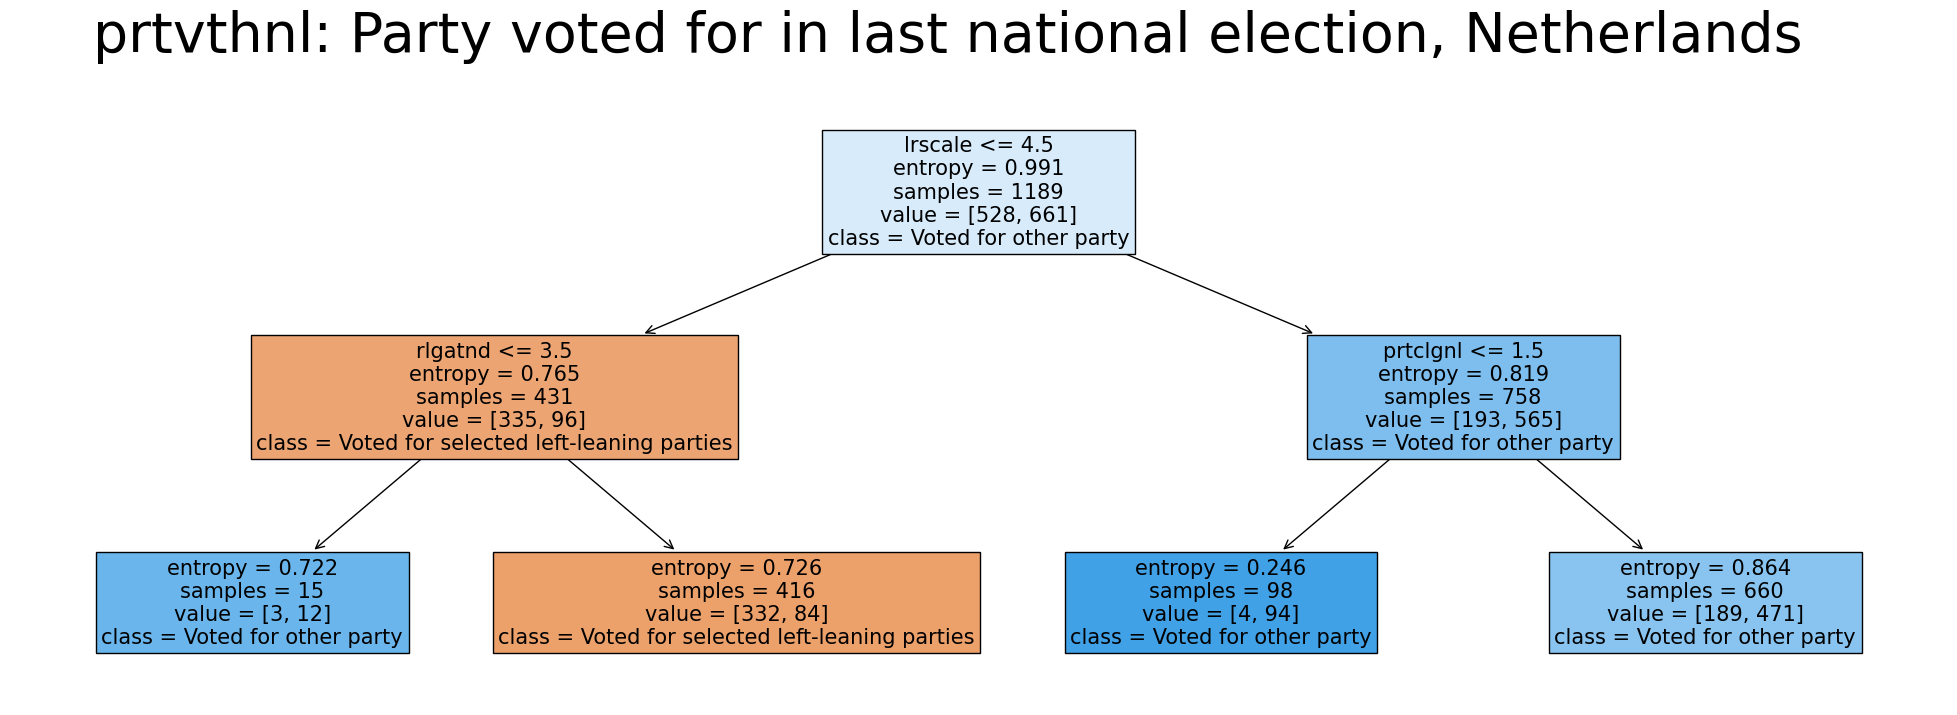

recursion: 0
Processing aim: prtvthnl: Party voted for in last national election, Netherlands
[]
recursion: 1
Processing aim: prtvthnl: Party voted for in last national election, Netherlands
[]
recursion: 2
Processing aim: prtvthnl: Party voted for in last national election, Netherlands
[]
recursion: 3
Processing aim: prtvthnl: Party voted for in last national election, Netherlands
[4]


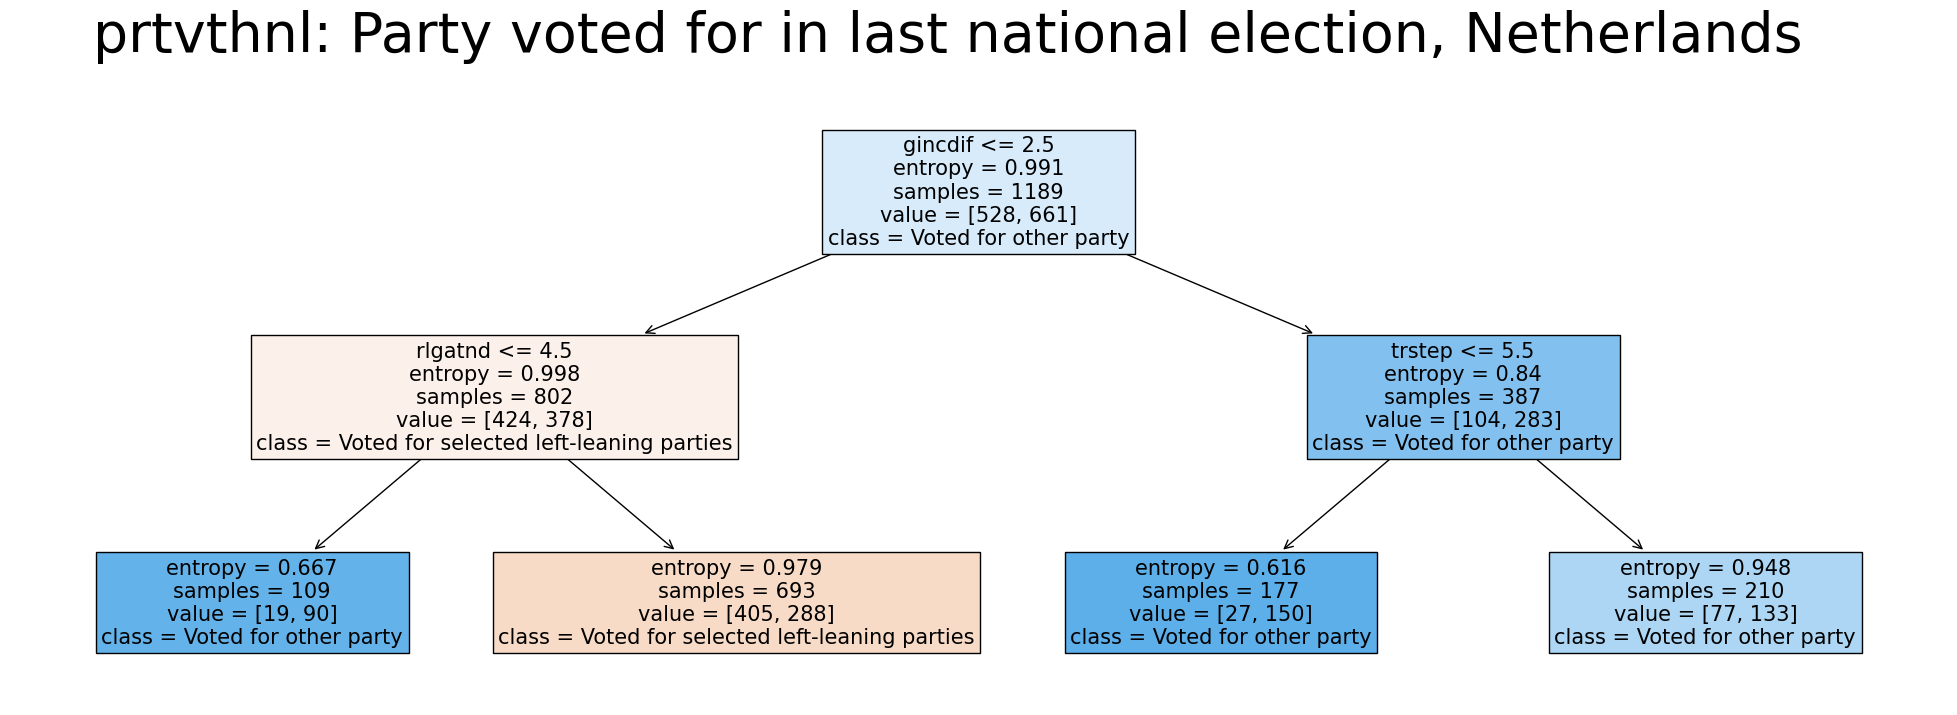

recursion: 4
Processing aim: prtvthnl: Party voted for in last national election, Netherlands
[]
recursion: 5
Processing aim: prtvthnl: Party voted for in last national election, Netherlands
[]
recursion: 6
Processing aim: prtvthnl: Party voted for in last national election, Netherlands
[]
recursion: 7
Processing aim: prtvthnl: Party voted for in last national election, Netherlands
[]
recursion: 8
Processing aim: prtvthnl: Party voted for in last national election, Netherlands
[]
recursion: 9
Processing aim: prtvthnl: Party voted for in last national election, Netherlands
[]
recursion: 10
Processing aim: prtvthnl: Party voted for in last national election, Netherlands
[]
recursion: 11
Processing aim: prtvthnl: Party voted for in last national election, Netherlands
[]
recursion: 12
Processing aim: prtvthnl: Party voted for in last national election, Netherlands
[]
recursion: 13
Processing aim: prtvthnl: Party voted for in last national election, Netherlands
[]
recursion: 14
Processing a

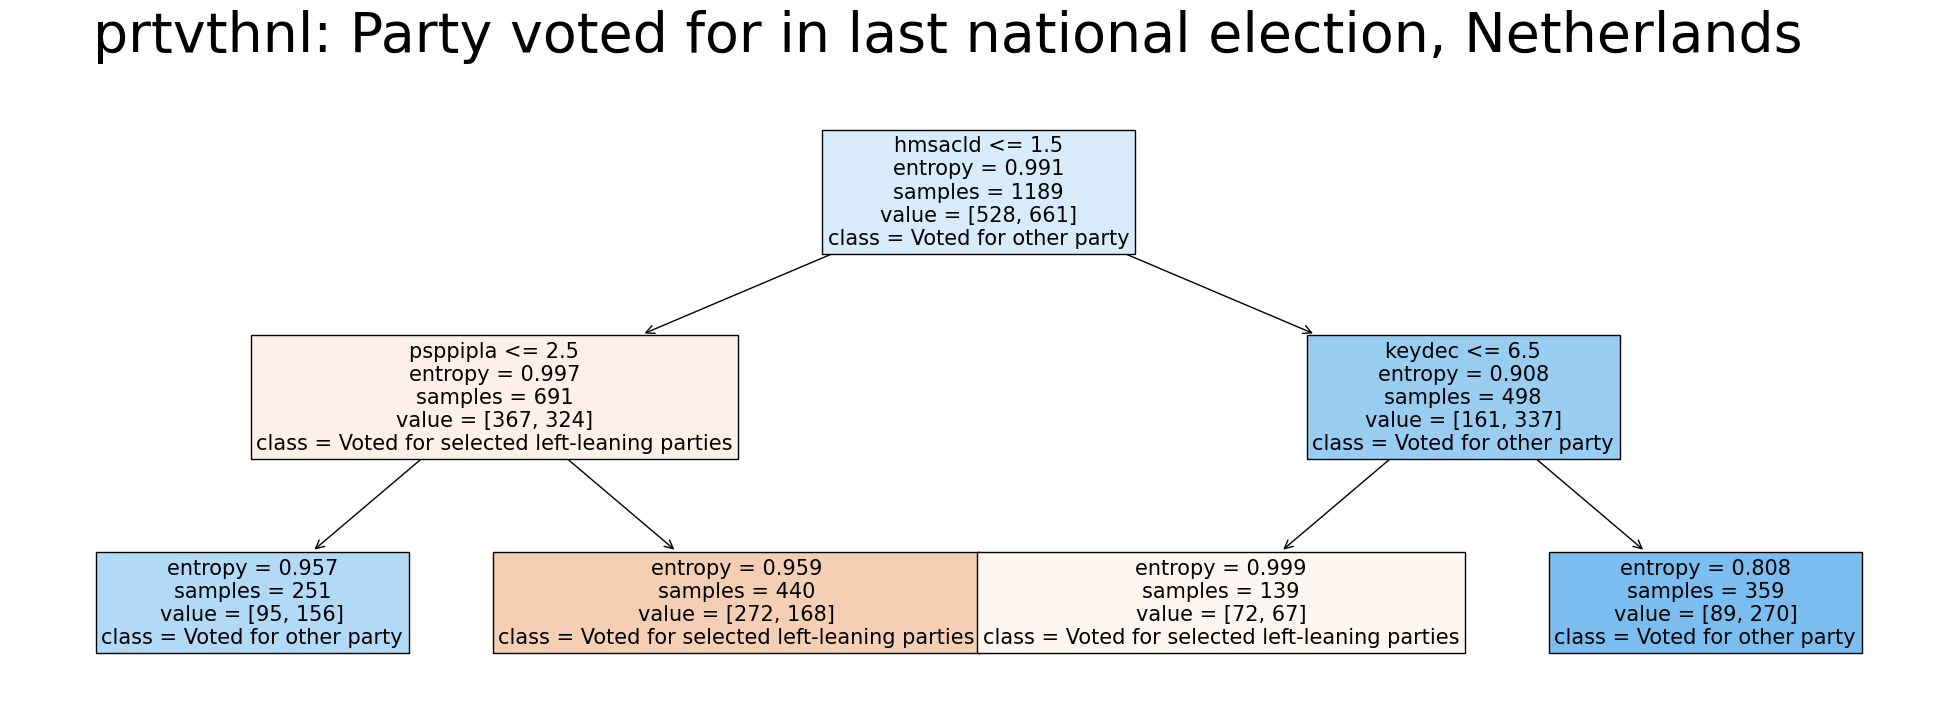

recursion: 17
Processing aim: prtvthnl: Party voted for in last national election, Netherlands
[]
recursion: 18
Processing aim: prtvthnl: Party voted for in last national election, Netherlands
[]
recursion: 19
Processing aim: prtvthnl: Party voted for in last national election, Netherlands
[]


,Attribute,Aim,Aim_description,Aim_resp,Total_count,Aim_%_True,Condition1,Condition1_description,Condition1_resp,Condition1_count,Condition1_Aim_%,Condition2,Condition2_description,Condition2_resp,Condition2_count,Condition2_Aim_%,final_entropy
0,People,prtvthnl,"Party voted for in last national election, Net...",Voted for selected left-leaning parties,1189,0.444071,lrscale,Placement on left right scale,"Left, 1, where 0: Left and 10: Right, 2, where...",431,0.777262,"(None,)",None,None,431,0.777262,0.765135
1,People,prtvthnl,"Party voted for in last national election, Net...",Voted for selected left-leaning parties,1189,0.444071,lrscale,Placement on left right scale,"Left, 1, where 0: Left and 10: Right, 2, where...",431,0.777262,rlgatnd,How often attend religious services apart from...,"At least once a month, Only on special holy da...",416,0.798077,0.725758
2,People,prtvthnl,"Party voted for in last national election, Net...",Voted for other party,1189,0.555929,lrscale,Placement on left right scale,"5, where 0: Left and 10: Right, 6, where 0: Le...",758,0.745383,"(None,)",None,None,758,0.745383,0.818515
3,People,prtvthnl,"Party voted for in last national election, Net...",Voted for other party,1189,0.555929,gincdif,Government should reduce differences in income...,"Neither agree nor disagree, Disagree, Disagree...",387,0.731266,"(None,)",None,None,387,0.731266,0.839642
4,People,prtvthnl,"Party voted for in last national election, Net...",Voted for other party,1189,0.555929,hmsacld,Gay and lesbian couples right to adopt children,"Agree, Neither agree nor disagree, Disagree, D...",498,0.676707,keydec,Key decisions are made by national governments...,"7, where 0: Not at all important for democracy...",359,0.752089,0.807950


In [29]:
#You can change these values:
entropy_threshold = 0.85 #How much entropy can the node have (yes aim:no aim) to be considered?
sample_threshold = 0.3 #What proportion of the original sample size to be considered?

# Select which aim and condition questions you would like to visualize in the Parallel set diagram
aim = 'prtvthnl'

# response_resampled= pd.concat([adjusted_responses[adjusted_responses[aim]==15], adjusted_responses[adjusted_responses[aim]!=15].sample(50)])
numerical_answers = adjusted_responses[common_columns].iloc[:,1:]

# Try converting each column to numeric and coerce errors to NaN
for column in numerical_answers.columns:
    numerical_answers[column] = pd.to_numeric(numerical_answers[column], errors='coerce')

# Drop columns that contain any NaN values (i.e., non-convertible columns)
numerical_answers = numerical_answers.dropna(axis=1, how='any')
conditions = numerical_answers.loc[:, ~numerical_answers.columns.isin([aim])].columns

statement_questions =  select_statements(aim, conditions, numerical_answers, statement_questions, "People", entropy_threshold, sample_threshold, 0)

display(statement_questions)

# Extract unique values from each column
unique_condition1 = statement_questions["Condition1"].unique()
unique_condition2 = statement_questions["Condition2"].unique()

# Combine the unique values into a single list
selected_conditions = list(unique_condition1) + list(unique_condition2)

# Get the unique items from the combined list
selected_conditions = list(set(selected_conditions))
# Remove None values
selected_conditions = [item for item in selected_conditions if item != (None,)]

# Save the DataFrame to a CSV file
statement_questions.to_csv("ESS_tree_selected_statements.csv", index=False)

Visualizing selected conditions:

In [30]:
for b in ['rlgatnd', 'prtclgnl', 'trstep']:
    print(b, adjusted_overview[adjusted_overview['id']==b]['question'].iloc[0])

rlgatnd How often attend religious services apart from special occasions
prtclgnl Which party feel closer to, Netherlands
trstep Trust in the European Parliament


In [351]:
for condition in selected_conditions:
    print(condition, adjusted_overview[adjusted_overview['id']==condition]['question'].iloc[0])
    display(adjusted_overview[adjusted_overview['id']==condition])

gincdif Government should reduce differences in income levels


,id,question,value,response,question_answers_combined,ADICO_Category,IG_Component
respid,,,,,,,
gincdif1,gincdif,Government should reduce differences in income...,1,Agree,Government should reduce differences in income...,Condition,if they agree that government should reduce di...
gincdif5,gincdif,Government should reduce differences in income...,5,Do not agree,Government should reduce differences in income...,NaN,if they do not agree that government should re...


rlgatnd How often attend religious services apart from special occasions


,id,question,value,response,question_answers_combined,ADICO_Category,IG_Component
respid,,,,,,,
rlgatnd1,rlgatnd,How often attend religious services apart from...,1,attends religious services,How often attend religious services apart from...,Aim,if they attend religious services
rlgatnd7,rlgatnd,How often attend religious services apart from...,7,rarely attends religious services,How often attend religious services apart from...,Condition,if they rarely attend religious services


hmsacld Gay and lesbian couples right to adopt children


,id,question,value,response,question_answers_combined,ADICO_Category,IG_Component
respid,,,,,,,
hmsacld1,hmsacld,Gay and lesbian couples right to adopt children,1,Agree,Gay and lesbian couples right to adopt childre...,Condition,if they agree that gay and lesbian couples hav...
hmsacld5,hmsacld,Gay and lesbian couples right to adopt children,5,Do not agree,Gay and lesbian couples right to adopt childre...,Condition,if they do not agree that gay and lesbian coup...


keydec Key decisions are made by national governments rather than the European Union


,id,question,value,response,question_answers_combined,ADICO_Category,IG_Component
respid,,,,,,,
keydec1,keydec,Key decisions are made by national governments...,1,Not important for democracy,Key decisions are made by national governments...,Aim,if they think that key decisions are not made ...
keydec10,keydec,Key decisions are made by national governments...,10,Important for democracy,Key decisions are made by national governments...,Condition,if they think that key decisions are made by n...


lrscale Placement on left right scale


,id,question,value,response,question_answers_combined,ADICO_Category,IG_Component
respid,,,,,,,
lrscale1,lrscale,Placement on left right scale,1,Consider themselves more left,Placement on left right scale - With response:...,Condition,if they consider themselves more left
lrscale10,lrscale,Placement on left right scale,10,Consider themselves more right,Placement on left right scale - With response:...,NaN,if they consider themselves more right


In [165]:
#encoding question responses (How often attend religious services )
adjusted_overview = adjusted_overview.loc[((adjusted_overview['id'] != 'rlgatnd') | ((adjusted_overview['id'] == 'rlgatnd') & (pd.to_numeric(adjusted_overview['value'], errors='coerce').isin([1,7]))))] #exclude values not 1,7

# Update response text:
adjusted_overview.loc[(adjusted_overview["id"] == "rlgatnd") & (pd.to_numeric(adjusted_overview['value'], errors='coerce') == 1), "response"] = "attends religious services" #"value" == 1 into "attends religious services"
adjusted_overview.loc[(adjusted_overview["id"] == "rlgatnd") & (pd.to_numeric(adjusted_overview['value'], errors='coerce') == 7), "response"] = "rarely attends religious services" #where "value" == 7 into "rarely attends religious services"

#encoding question responses (Placement on left right scale)
adjusted_overview = adjusted_overview.loc[((adjusted_overview['id'] != 'lrscale') | ((adjusted_overview['id'] == 'lrscale') & (pd.to_numeric(adjusted_overview['value'], errors='coerce').isin([1,10]))))] #exclude values not 1,10

# Update response text:
adjusted_overview.loc[(adjusted_overview["id"] == "lrscale") & (pd.to_numeric(adjusted_overview['value'], errors='coerce') == 1), "response"] = "Consider themselves more left" #"value" == 1 into "more left" 
adjusted_overview.loc[(adjusted_overview["id"] == "lrscale") & (pd.to_numeric(adjusted_overview['value'], errors='coerce') == 10), "response"] = "Consider themselves more right" #where "value" == 10 into "more right"

#encoding question responses (Government should reduce differences in income)
adjusted_overview = adjusted_overview.loc[((adjusted_overview['id'] != 'gincdif') | ((adjusted_overview['id'] == 'gincdif') & (pd.to_numeric(adjusted_overview['value'], errors='coerce').isin([1,5]))))] #exclude values not 1,5

# Update response text:
adjusted_overview.loc[(adjusted_overview["id"] == "gincdif") & (pd.to_numeric(adjusted_overview['value'], errors='coerce') == 1), "response"] = "Agree" #"value" == 1 into "Agree"
adjusted_overview.loc[(adjusted_overview["id"] == "gincdif") & (pd.to_numeric(adjusted_overview['value'], errors='coerce') == 5), "response"] = "Do not agree" #where "value" == 5 into "Do not agree"

#encoding question responses (Key decisions are made by national governments)
adjusted_overview = adjusted_overview.loc[((adjusted_overview['id'] != 'keydec') | ((adjusted_overview['id'] == 'keydec') & (pd.to_numeric(adjusted_overview['value'], errors='coerce').isin([1,10]))))] #exclude values not 1,10
# Update response text:
adjusted_overview.loc[(adjusted_overview["id"] == "keydec") & (pd.to_numeric(adjusted_overview['value'], errors='coerce') == 1), "response"] = "Not important for democracy" #"value" == 1 into "Not important for democracy"
adjusted_overview.loc[(adjusted_overview["id"] == "keydec") & (pd.to_numeric(adjusted_overview['value'], errors='coerce') == 10), "response"] = "Important for democracy" #where "value" == 10 into "Important for democracy"

#encoding question responses (Gay and lesbian couples right to adopt children)
adjusted_overview = adjusted_overview.loc[((adjusted_overview['id'] != 'hmsacld') | ((adjusted_overview['id'] == 'hmsacld') & (pd.to_numeric(adjusted_overview['value'], errors='coerce').isin([1,5]))))] #exclude values not 1,5
# Update response text:
adjusted_overview.loc[(adjusted_overview["id"] == "hmsacld") & (pd.to_numeric(adjusted_overview['value'], errors='coerce') == 1), "response"] = "Agree" #"value" == 1 into "Agree"
adjusted_overview.loc[(adjusted_overview["id"] == "hmsacld") & (pd.to_numeric(adjusted_overview['value'], errors='coerce') == 5), "response"] = "Do not agree" #where "value" == 5 into "Do not agree"


# Update adjusted_responses dataframe
adjusted_responses = adjusted_responses.loc[(adjusted_responses['rlgatnd'].isnull()) | (pd.to_numeric(adjusted_responses['rlgatnd'], errors='coerce') <= 7)]
adjusted_responses.loc[pd.to_numeric(adjusted_responses['rlgatnd'], errors='coerce') > 5, 'rlgatnd'] = 7
adjusted_responses.loc[pd.to_numeric(adjusted_responses['rlgatnd'], errors='coerce') < 6, 'rlgatnd'] = 1

adjusted_responses = adjusted_responses.loc[(adjusted_responses['lrscale'].isnull()) | (pd.to_numeric(adjusted_responses['lrscale'], errors='coerce') <= 10)]
adjusted_responses.loc[pd.to_numeric(adjusted_responses['lrscale'], errors='coerce') > 4, 'lrscale'] = 10
adjusted_responses.loc[pd.to_numeric(adjusted_responses['lrscale'], errors='coerce') < 5, 'lrscale'] = 1

adjusted_responses = adjusted_responses.loc[(adjusted_responses['gincdif'].isnull()) | (pd.to_numeric(adjusted_responses['gincdif'], errors='coerce') <= 5)]
adjusted_responses.loc[pd.to_numeric(adjusted_responses['gincdif'], errors='coerce') > 2, 'gincdif'] = 5
adjusted_responses.loc[pd.to_numeric(adjusted_responses['gincdif'], errors='coerce') < 3, 'gincdif'] = 1

adjusted_responses = adjusted_responses.loc[(adjusted_responses['keydec'].isnull()) | (pd.to_numeric(adjusted_responses['keydec'], errors='coerce') <= 10)]
adjusted_responses.loc[pd.to_numeric(adjusted_responses['keydec'], errors='coerce') > 5, 'keydec'] = 10
adjusted_responses.loc[pd.to_numeric(adjusted_responses['keydec'], errors='coerce') < 6, 'keydec'] = 1

adjusted_responses = adjusted_responses.loc[(adjusted_responses['hmsacld'].isnull()) | (pd.to_numeric(adjusted_responses['hmsacld'], errors='coerce') <= 5)]
adjusted_responses.loc[pd.to_numeric(adjusted_responses['hmsacld'], errors='coerce') > 2, 'hmsacld'] = 5
adjusted_responses.loc[pd.to_numeric(adjusted_responses['hmsacld'], errors='coerce') < 3, 'hmsacld'] = 1

In [375]:
#Import the required package
import plotly.express as px
import random

# sample_conditions = random.sample(selected_conditions,2)
# Select which aim and condition questions you would like to visualize in the Parallel set diagram
questions = [aim] + sample_conditions

paralelsetdf= adjusted_responses[questions].astype(str)

# Define custom color mapping
color_mapping = {
    "15.0": "#00a6d6",
    "31.0": "#a7a7a7"
}

# Apply color mapping
paralelsetdf['color'] = paralelsetdf[aim].map(color_mapping)

diagram_headers = ["Voted for?"]

# Update labels to provide the need
aimcounts = paralelsetdf[aim].value_counts()
paralelsetdf.loc[paralelsetdf[aim] == str(15.0), aim] = f"Voted for a<br>left-leaning party<br>({aimcounts.loc[str(15.0)]})"
paralelsetdf.loc[paralelsetdf[aim] == str(31.0), aim] = f"Voted for<br>another party<br>({aimcounts.loc[str(31.0)]})"

for condition in sample_conditions:
    conditioncounts = paralelsetdf[condition].value_counts()

    for val in paralelsetdf[condition].unique():
        # Calculate the percentage of people that do the aim within the condition value
        condition_percentage = (len(paralelsetdf[(paralelsetdf[condition]==val)&(paralelsetdf["color"]=="#00a6d6")]) / conditioncounts.loc[val] * 100).round(1)
        # Update condition labels
        label = adjusted_overview.loc[(adjusted_overview['id'] == condition) & (adjusted_overview['value'] == val), "response"].iloc[0]

        paralelsetdf.loc[paralelsetdf[condition] == val, condition] = f"{label}<br>n = {conditioncounts.loc[val]}<br>Voted Left: {condition_percentage}%"
        
    diagram_headers += [adjusted_overview[adjusted_overview['id']==condition]['question'].iloc[0]]
    # diagram_headers = ["Frequent use?", "Age?", "Percieved Price", "Peer pressure to use?"]

paralelsetdf.columns = diagram_headers + ["color"]

# Create the parallel categories plot
fig = px.parallel_categories(
    paralelsetdf,
    dimensions=diagram_headers,
    color='color',
    labels={col: col for col in diagram_headers},
)

# Update the layout of the figure with a title, font size, and margins
fig.update_layout(
    title_text="People: " + adjusted_overview[adjusted_overview['id'] == aim]["question"].iloc[0], 
    height=700,
    width=1400,
    title_font=dict(size=30),  # Set title font size here
    font=dict(size=18),  # Set default font size here (for labels, etc.)
    margin=dict(l=205, r=100, t=50, b=50)  # Add margins
)

# Adjust the position of the parallel categories
fig.update_xaxes(domain=[0.1, 0.9])

# Show the plot
fig.show()

In [167]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
import json
import sys
# Add the parent directory to the path
sys.path.append('..')
# Now you can import the private values defined in config
from config import groqkey #API keys should always be kept in a separate config file that you never share
#Currently you can request an API from Groq and make api calls for free!

In [168]:
adjusted_overview['IG_Component'] = ""

In [169]:
#Ask Generative AI to rewrite the Json Approach
#groq offers these models:
models = ["gemma-7b-it", "llama3-8b-8192", "mixtral-8x7b-32768", "llama3-70b-8192"]
# Define the LLM, models[1] represents "llama3-8b-8192"
llm = ChatGroq(temperature=0, model=models[1], api_key=groqkey)

#if you prefer to use openAI (requires paid API access):
# models = ["gpt-3.5-turbo-0125", "gpt-4o"]
# llm = ChatOpenAI(temperature=0, model=models[1], api_key=OPENAI_Key)

#You can experiment with the system instructions given to the ai, this section was excluded because I considered it redundant but it can always be added
"""Here is an example: "Attribute": "People", "Aim":"do this specific action", "Condition1": "if this condition is met", "Condition2": "and this condition is met" 
 I should be able to combine any output Attribute + Aim + Condition to form a full 3rd-person sentence that describes behaviour. """

#Function that gets the response from the LLM model and reads it into a table, the function takes a dataframe table of the survey overview, 
# preferably provide it with a subset of the survey overview of Aims, Conditions or Attributes and indicate this in the ADICO_component value.
def IGCompletionFunction(questions, ADICO_component):
    #create an empty table with the output column:
    IG_components = pd.DataFrame(columns=["IG_Component"])
    
    question = questions['id']

    # Prepares the provided overview table for the LLM 
    questionset = questions[questions['id'] == question][["question","response"]]
    request = questionset.to_json(orient='index', index=True)        

    #The general instructions for the LLM
    system = f"""You are a json interpreter that transforms survey questions and responses into structured informal rule institutional statement components in 3rd person.
                The input json will have the following structure:
                Object Key = identifier of question and answer pair
                With nested values
                question: Text of the question being asked
                response = a response option for the question    

                You output json must have the following structure:
                Object Key = the same identifier of question and answer pair
                IG_Component = The rewritten question and answer 

                Interpret the meaning of the response option, rewrite it; be concise and avoid simplifing or generalising the actions and conditions.  
                Always produce a single JSON containing the same (number of) question identifiers  as have been provided.

                In this instance the questions you have been provided are '{ADICO_component}'. Perform the text conversion below.
                """     
    #Additional information for the LLM that depends on the "ADICO_component" given:
    system +=   {'Attributes':'demographic of the survey responses, should be written as "People (rewritten question and answer)" e.g. "People who are male"', #if "ADICO_component" is Attributes
                'Aims': "action question and the response, should be written as an action that precedes the subject of the sentence  e.g. 'sell their house', do not include the subject of the sentence", #if "ADICO_component" is Aims
                'Conditions': "condition question and response, should be rewritten as 'if (rewritten question and answer)' in 3rd person ('they') e.g. 'if they feel they cannot rely on government support'"}[ADICO_component] #if "ADICO_component" is Conditions 

    #Combines and formats the message and system instructions for the LLM  
    human = "{text}"
    prompt  = ChatPromptTemplate.from_messages([("system", system), ("human", human)])

    #Sends the request to the LLM to get a response
    chain = prompt | llm
    response = chain.invoke({"text": request})

    # Extract the JSON string from the LLM response text
    start = response.content.find("{")
    end = response.content.rfind("}") + 1
    json_str = response.content[start:end]

    # Parse the JSON string into a Python dictionary
    try:
        data_dict = json.loads(json_str)        
    except: 
        # Replace all instances of "}}" with "}", and remove any incorrect json formatting
        json_str = json_str.replace("}}", "}")+"}"
        json_str = json_str.replace(",\n{", ",\n")
        json_str = json_str.replace(",{", ",")

        # Load the JSON string into a dictionary
        data_dict = json.loads(json_str)
    
    # Read the processed response as a dataframe
    IG_components = pd.concat([IG_components, pd.DataFrame.from_dict(data_dict, orient='index')])
    
    return IG_components

# adjusted_overview['IG_Component'] = ""
# Update adjusted_overview with values from the LLM's response
#Handle each question separately to avoid confusion:
for question in adjusted_overview[(adjusted_overview['id'].isin(selected_conditions)) & (adjusted_overview['IG_Component'] == "")]['id'].unique():
        adjusted_overview.update(IGCompletionFunction(adjusted_overview[adjusted_overview['id'] == question], "Conditions"))
        print(question, "done")
adjusted_overview.update(IGCompletionFunction(adjusted_overview[adjusted_overview['id'].isin([aim])], "Aims"))

lrscale done
gincdif done
hmsacld done
rlgatnd done
keydec done


In [170]:
adjusted_overview[adjusted_overview['IG_Component'] != ""]

,id,question,value,response,question_answers_combined,ADICO_Category,IG_Component
respid,,,,,,,
prtvthnl15,prtvthnl,"Party voted for in last national election, Net...",15,Voted for selected left-leaning parties,"Party voted for in last national election, Net...",NaN,Voted for selected left-leaning parties
prtvthnl31,prtvthnl,"Party voted for in last national election, Net...",31,Voted for other party,"Party voted for in last national election, Net...",NaN,Voted for other party
lrscale1,lrscale,Placement on left right scale,1,Consider themselves more left,Placement on left right scale - With response:...,Condition,if they consider themselves more left
lrscale10,lrscale,Placement on left right scale,10,Consider themselves more right,Placement on left right scale - With response:...,NaN,if they consider themselves more right
gincdif1,gincdif,Government should reduce differences in income...,1,Agree,Government should reduce differences in income...,Condition,if they agree that government should reduce di...
gincdif5,gincdif,Government should reduce differences in income...,5,Do not agree,Government should reduce differences in income...,NaN,if they do not agree that government should re...
hmsacld1,hmsacld,Gay and lesbian couples right to adopt children,1,Agree,Gay and lesbian couples right to adopt childre...,Condition,if they agree that gay and lesbian couples hav...
hmsacld5,hmsacld,Gay and lesbian couples right to adopt children,5,Do not agree,Gay and lesbian couples right to adopt childre...,Condition,if they do not agree that gay and lesbian coup...
rlgatnd1,rlgatnd,How often attend religious services apart from...,1,attends religious services,How often attend religious services apart from...,Aim,if they attend religious services


Visualise the selected conditions

In [194]:
# Function that takes a tree and an index value of a tree node that satisfies the conditions to be a statement and generates a row for the statement table
def makeTreeStatement(tree, satisfactory_index, classes, features, attributeGroup, aim, Aim_description):
    # Get the aim outcome of the node (which action has more samples)
    class_index = np.argmax(tree.value[satisfactory_index])  
    Aim_resp = classes[class_index]
    # Retrieve the class counts at the root node
    aim_resp_count = tree.value[0][0]  # Gets the counts for each class
    
    # get how many in people answered with this aim outcome
    total_aim_percent = aim_resp_count[class_index]/tree.n_node_samples[0]

    if satisfactory_index == 0:
        condition2 = condition1 = None, 
        Condition2_description = Condition1_description = None
        condition2_rows_of_leaf = condition1_rows_of_leaf = ["None"] 
        condition2_count = condition1_count = tree.n_node_samples[0]
        condition2_aim_resp_percent = condition1_aim_resp_percent = total_aim_percent
    else:
        condition1 = features[tree.feature[0]]   # Get the condition used for the root node
        #get the description of the first condition question used
        Condition1_description = adjusted_overview[adjusted_overview["id"] == condition1.strip()]['question'].iat[0]
        #Rows of question data for condition1
        condition1_rows = adjusted_overview[adjusted_overview['id'] == condition1]

        satisfactory_leaf_is_left = tree.feature[satisfactory_index - 1] != -2  # Determine if the leaf is on the "left"
        
        if satisfactory_leaf_is_left: # The leaf meets the threshold      
            leaf_parent_index = satisfactory_index - 1
        else:  # The leaf does not meet the threshold (falls outside the threshold)
            leaf_parent_index = satisfactory_index - 2
            if tree.feature[leaf_parent_index] == -2: #was directly connected to root and on the right 
                leaf_parent_index = 0

        if leaf_parent_index != 0: #if the leaf is not directly connected to the root node
            root_threshold = tree.threshold[0]  # get the threshold used on the root node
            parent_is_left = leaf_parent_index - 1 == 0  # Determine if the parent is on the "left"

            # Set 'in_thresh' based on whether the condition is met (leaf is within the threshold)
            if parent_is_left: # The parent meets the threshold
                condition1_rows_of_leaf = condition1_rows[condition1_rows['value'].astype(float) <= root_threshold]['IG_Component']

            else: # The leaf does not meet the threshold
                condition1_rows_of_leaf = condition1_rows[condition1_rows['value'].astype(float) > root_threshold]['IG_Component']
                    
            condition1_count = tree.n_node_samples[leaf_parent_index]
            condition1_aim_resp_percent = tree.value[leaf_parent_index][0, class_index]/condition1_count
            condition2 = features[tree.feature[leaf_parent_index]]
            Condition2_description = Survey_Overview[Survey_Overview["id"] == condition2.strip()]['question'].iat[0]

            threshold2 = tree.threshold[leaf_parent_index]  # get the threshold used on the least entropy leaf
            #Rows of question data for this condition
            condition2_rows = adjusted_overview[adjusted_overview['id'] == condition2]
      
            if satisfactory_leaf_is_left:
                condition2_rows_of_leaf = condition2_rows[condition2_rows['value'].astype(float) <= threshold2]['IG_Component']

            else: 
                condition2_rows_of_leaf = condition2_rows[condition2_rows['value'].astype(float) > threshold2]['IG_Component']

            condition2_count = tree.n_node_samples[satisfactory_index]
            condition2_aim_resp_percent = tree.value[satisfactory_index][0][np.argmax(tree.value[satisfactory_index][0])]/condition2_count
    
        else:
            condition1 = features[tree.feature[leaf_parent_index]]
            parent_threshold = tree.threshold[leaf_parent_index]  # get the threshold used on the least entropy leaf
            #Rows of question data for this condition
            condition1_rows = adjusted_overview[adjusted_overview['id'] == condition1]

            if satisfactory_leaf_is_left:
                condition1_rows_of_leaf = condition1_rows[condition1_rows['value'].astype(float) <= parent_threshold]['IG_Component']
            else: 
                condition1_rows_of_leaf = condition1_rows[condition1_rows['value'].astype(float) > parent_threshold]['IG_Component']

            condition1_count = tree.n_node_samples[satisfactory_index]
            condition1_aim_resp_percent = tree.value[satisfactory_index][0][np.argmax(tree.value[satisfactory_index][0])]/condition1_count
            
            condition2 = None
            Condition2_description = None
            condition2_rows_of_leaf = ["None"] 
            condition2_count = condition1_count
            condition2_aim_resp_percent = condition1_aim_resp_percent

    # Create a new row with specified values
    new_row = {
        'Attribute': attributeGroup,

        'Aim': aim,
        'Aim_description': Aim_description,
        'Aim_resp': Aim_resp,  # Class with the lowest entropy
        'Total_count':tree.n_node_samples[0], 
        'Aim_%_True': total_aim_percent,

        'Condition1': condition1,
        'Condition1_description': Condition1_description,
        'Condition1_resp': ", ".join(condition1_rows_of_leaf),
        'Condition1_count': condition1_count,
        'Condition1_Aim_%': condition1_aim_resp_percent, 

        'Condition2': condition2, 
        'Condition2_description': Condition2_description,
        'Condition2_resp': ", ".join(condition2_rows_of_leaf), 
        'Condition2_count': condition2_count,
        'Condition2_Aim_%': condition2_aim_resp_percent,

        'final_entropy': tree.impurity[satisfactory_index]
    }
    return new_row

In [195]:
def select_statements(aim, conditions, responses, statement_questions, attributeGroup, entropy_threshold, sample_threshold, recursion):

    # Find the relevant row and value labels
    aimRow = adjusted_overview[adjusted_overview["id"] == aim]
    aimRow0 = str(aimRow.at[aimRow.index[0], "IG_Component"])
    aimRow1 = str(aimRow.at[aimRow.index[-1], "IG_Component"])
    classes = [aimRow0,aimRow1]

    Aim_description = adjusted_overview[adjusted_overview["id"] == aim.strip()]['question'].iat[0]

    print(f"Processing aim: {aim}: {str(aimRow.at[aimRow.index[0], 'question'])}")

    # Split the data
    condition_responses = responses[conditions].values
    aim_responses = responses.loc[:, aim].values

    sample_demographic_size = len(aim_responses)

    clf_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=2, min_samples_leaf=int(sample_threshold*sample_demographic_size))
    clf_entropy.fit(condition_responses, aim_responses)

    #list of the conditions we test
    features = conditions

    # 'clf_entropy' is your trained decision tree classifier
    tree = clf_entropy.tree_

    #Identify leaf indices (where feature is -2)
    leaf_indices = np.where(tree.feature == -2)[0]

    #Find nodes where entropy is within the threshold
    pure_enough_nodes = np.where(tree.impurity <= entropy_threshold)[0]
    #Find nodes which have enough samples is within the threshold
    enough_sample_nodes = np.where(tree.n_node_samples >= int(sample_threshold*sample_demographic_size))[0]
    # Find the intersection of both lists
    satisfactory_nodes = np.intersect1d(pure_enough_nodes, enough_sample_nodes)
    
    for node in satisfactory_nodes:
        new_row = makeTreeStatement(tree, node, classes, features, attributeGroup, aim, Aim_description)
        # Using a new index to add a row directly
        row_number = len(statement_questions)  # Determine the next index
        statement_questions.loc[row_number] = new_row
        # Drop duplicates if needed
        statement_questions = statement_questions.drop_duplicates()

    #find the leaf with the lowest entropy
    least_entropy_index = leaf_indices[np.argmin(tree.impurity[leaf_indices])]
    final_entropy = tree.impurity[least_entropy_index]

    if final_entropy < entropy_threshold: 
        # Visualize the decision tree
        plt.figure(figsize=(25, 8))

        plot_tree(clf_entropy, filled=True, feature_names=features, class_names=classes, fontsize=15)
        plt.suptitle(f"{aim}: {str(aimRow.at[aimRow.index[0], 'question'])}", fontsize=40)
        plt.show()
    
    if recursion < min(3, len(conditions)-2):
        recursion_conditions = [condition for condition in conditions if condition not in statement_questions["Condition1"].tolist()[-recursion:]]
        statement_questions = select_statements(aim, recursion_conditions, responses, statement_questions, attributeGroup, entropy_threshold, sample_threshold, recursion+1) 

    return statement_questions

Processing aim: prtvthnl: Party voted for in last national election, Netherlands


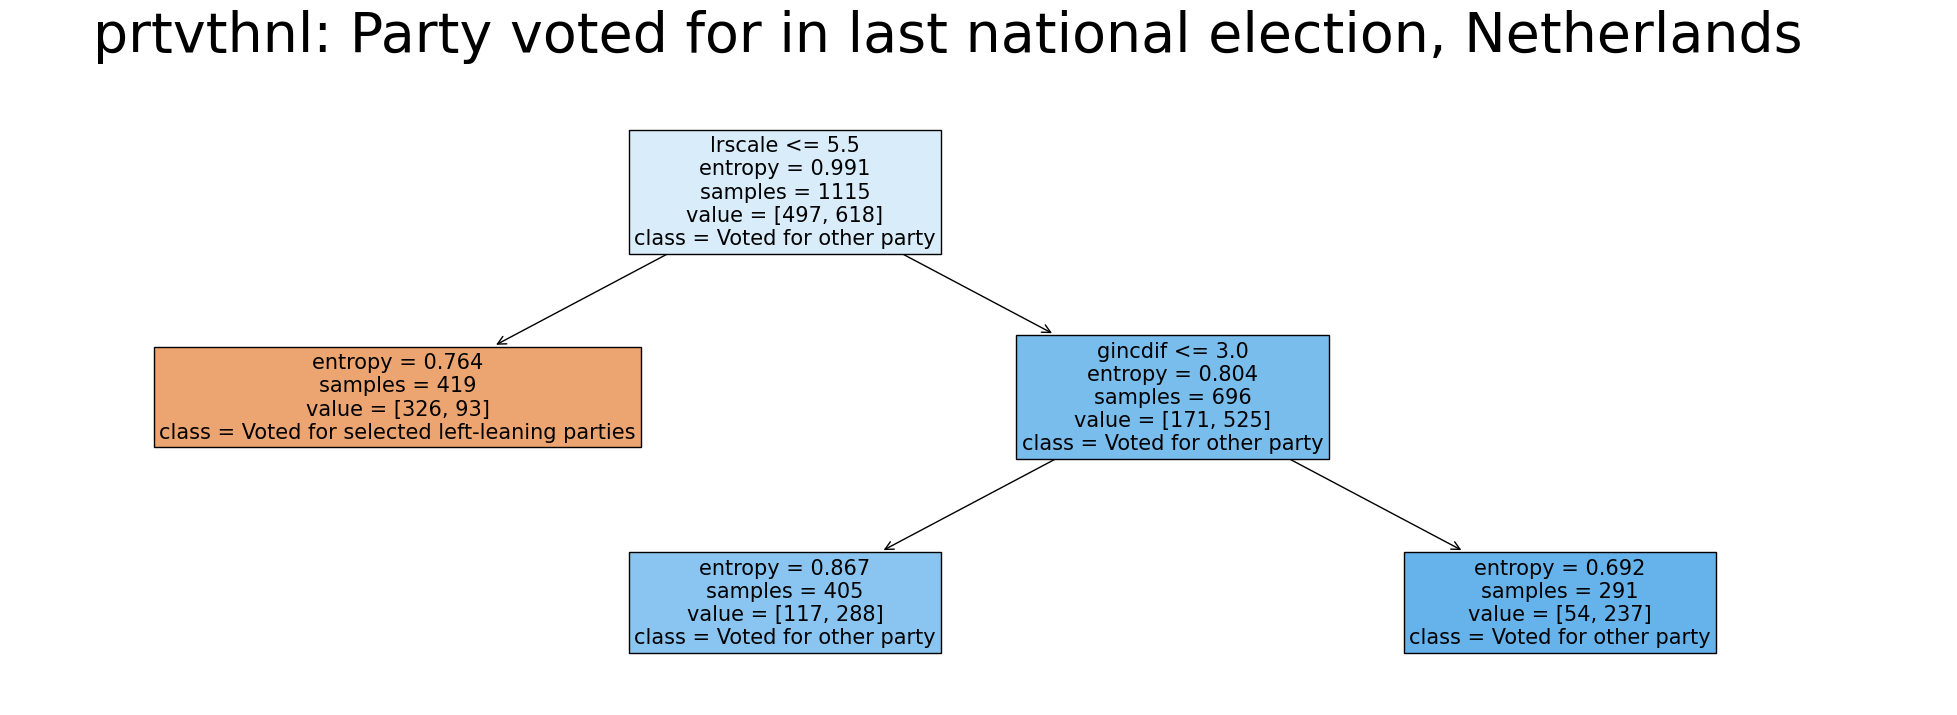

Processing aim: prtvthnl: Party voted for in last national election, Netherlands


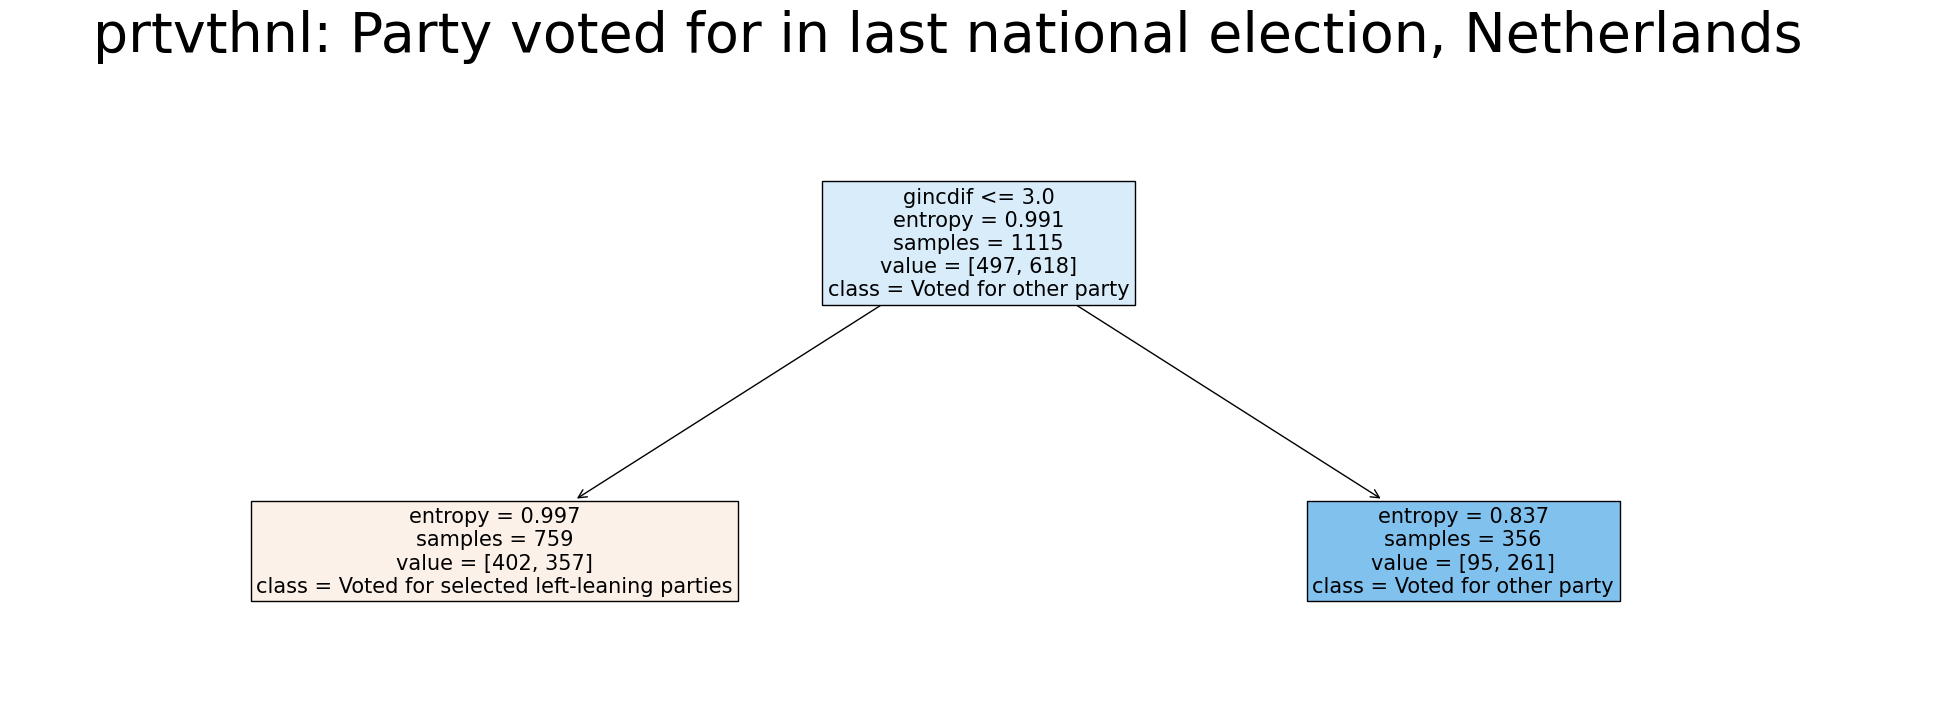

Processing aim: prtvthnl: Party voted for in last national election, Netherlands


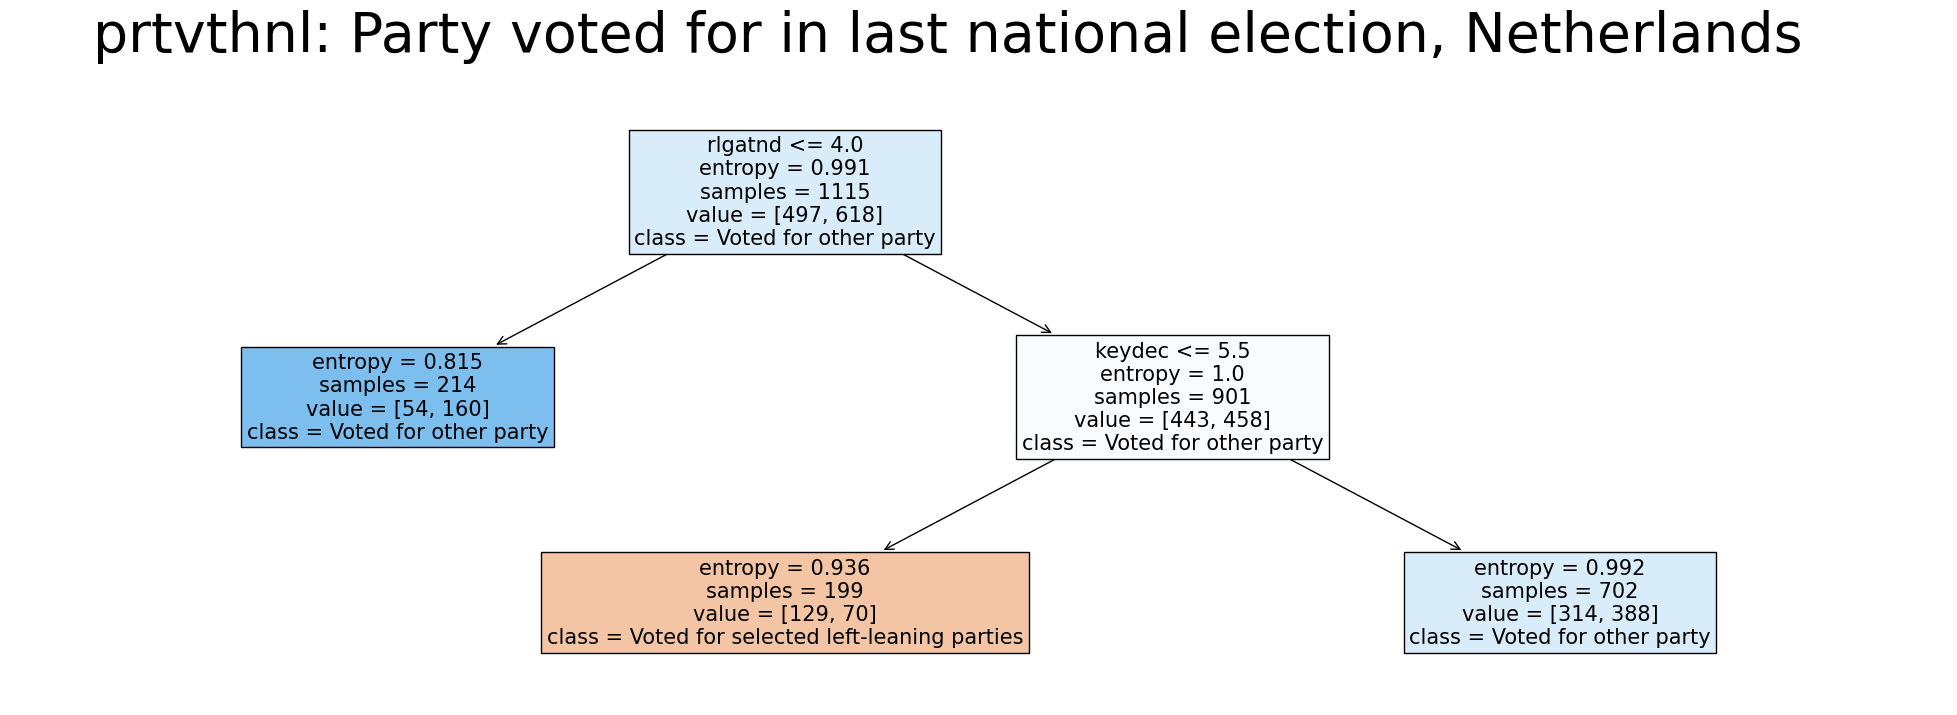

,Attribute,Aim,Aim_description,Aim_resp,Total_count,Aim_%_True,Condition1,Condition1_description,Condition1_resp,Condition1_count,Condition1_Aim_%,Condition2,Condition2_description,Condition2_resp,Condition2_count,Condition2_Aim_%,final_entropy
0,People,prtvthnl,"Party voted for in last national election, Net...",Voted for selected left-leaning parties,1115,0.44574,lrscale,Placement on left right scale,if they consider themselves more left,419,0.778043,None,None,None,419,0.778043,0.763725
1,People,prtvthnl,"Party voted for in last national election, Net...",Voted for other party,1115,0.55426,lrscale,Placement on left right scale,if they consider themselves more right,696,0.754310,None,None,None,696,0.754310,0.804375
2,People,prtvthnl,"Party voted for in last national election, Net...",Voted for other party,1115,0.55426,lrscale,Placement on left right scale,if they consider themselves more right,696,0.754310,gincdif,Government should reduce differences in income...,if they agree that government should reduce di...,405,0.711111,0.867282
3,People,prtvthnl,"Party voted for in last national election, Net...",Voted for other party,1115,0.55426,lrscale,Placement on left right scale,if they consider themselves more right,696,0.754310,gincdif,Government should reduce differences in income...,if they do not agree that government should re...,291,0.814433,0.692105
4,People,prtvthnl,"Party voted for in last national election, Net...",Voted for other party,1115,0.55426,gincdif,Government should reduce differences in income...,if they do not agree that government should re...,356,0.733146,None,None,None,356,0.733146,0.836914
5,People,prtvthnl,"Party voted for in last national election, Net...",Voted for other party,1115,0.55426,rlgatnd,How often attend religious services apart from...,if they attend religious services,214,0.747664,None,None,None,214,0.747664,0.814960
6,People,prtvthnl,"Party voted for in last national election, Net...",Voted for selected left-leaning parties,1115,0.44574,rlgatnd,How often attend religious services apart from...,if they rarely attend religious services,901,0.491676,keydec,Key decisions are made by national governments...,if they think that key decisions are not made ...,199,0.648241,0.935629


In [383]:
#create a table that will be filled by selected combinations of aims and conditions with the relevant information for further processing 
statement_questions = pd.DataFrame(columns = ['Attribute', 
                                              'Aim', 'Aim_description', 'Aim_resp', 'Total_count', 'Aim_%_True', 
                                              'Condition1', 'Condition1_description', 'Condition1_resp', 'Condition1_count', 'Condition1_Aim_%', 
                                              'Condition2', 'Condition2_description', 'Condition2_resp', 'Condition2_count', 'Condition2_Aim_%',
                                              'final_entropy'])

#You can change these values:
entropy_threshold = 0.95 #How much entropy can the node have (yes aim:no aim) to be considered?
sample_threshold = 0.15 #What proportion of the original sample size to be considered?

# Select which aim and condition questions you would like to visualize in the Parallel set diagram
aim = 'prtvthnl'
selcon= ['gincdif', 'rlgatnd', 'hmsacld', 'keydec', 'lrscale']

statement_questions =  select_statements(aim, selcon, adjusted_responses, statement_questions, "People", entropy_threshold, sample_threshold, 0)

display(statement_questions)


# Save the DataFrame to a CSV file
statement_questions.to_csv("ESS_tree_selected_statements_r2.csv", index=False)

In [384]:
statement_questions.sort_values("final_entropy",inplace=True)
statement_questions.reset_index(inplace=True, drop=True)

In [385]:
for row in statement_questions.index:
    print(statement_questions.loc[row, "Attribute"])
    print(statement_questions.loc[row, "Aim_resp"])
    print(statement_questions.loc[row, "Condition1_resp"])
    print("and", statement_questions.loc[row, "Condition2_resp"])
    print("Entropy:", statement_questions.loc[row, "final_entropy"],"\n")

People
Voted for other party
if they consider themselves more right
and if they do not agree that government should reduce differences in income levels
Entropy: 0.6921053253628725 

People
Voted for selected left-leaning parties
if they consider themselves more left
and None
Entropy: 0.7637249355791172 

People
Voted for other party
if they consider themselves more right
and None
Entropy: 0.804374635739435 

People
Voted for other party
if they attend religious services
and None
Entropy: 0.814960349490842 

People
Voted for other party
if they do not agree that government should reduce differences in income levels
and None
Entropy: 0.8369139144040948 

People
Voted for other party
if they consider themselves more right
and if they agree that government should reduce differences in income levels
Entropy: 0.8672816222000259 

People
Voted for selected left-leaning parties
if they rarely attend religious services
and if they think that key decisions are not made by national governments ra

Visualise the Institutional Grammar statements and values

In [386]:
import textwrap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

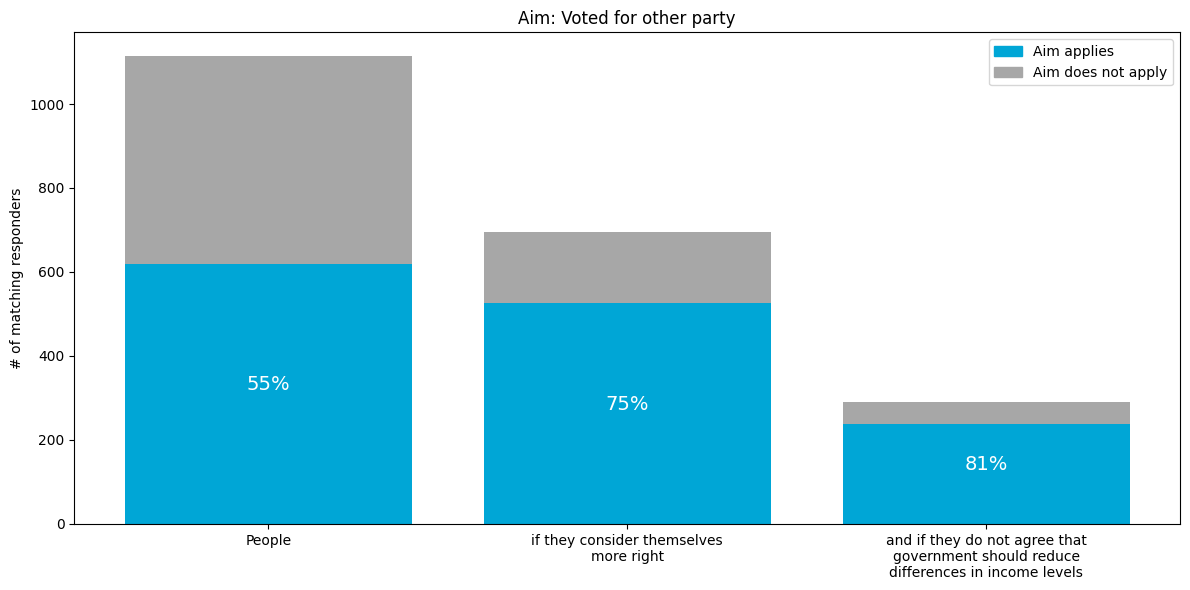

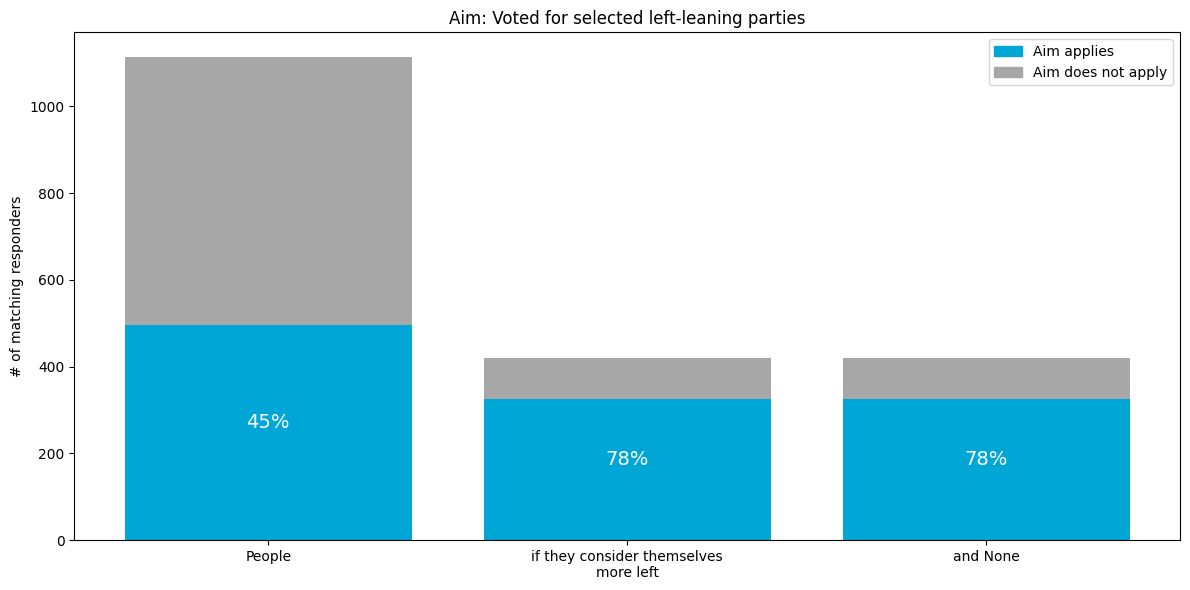

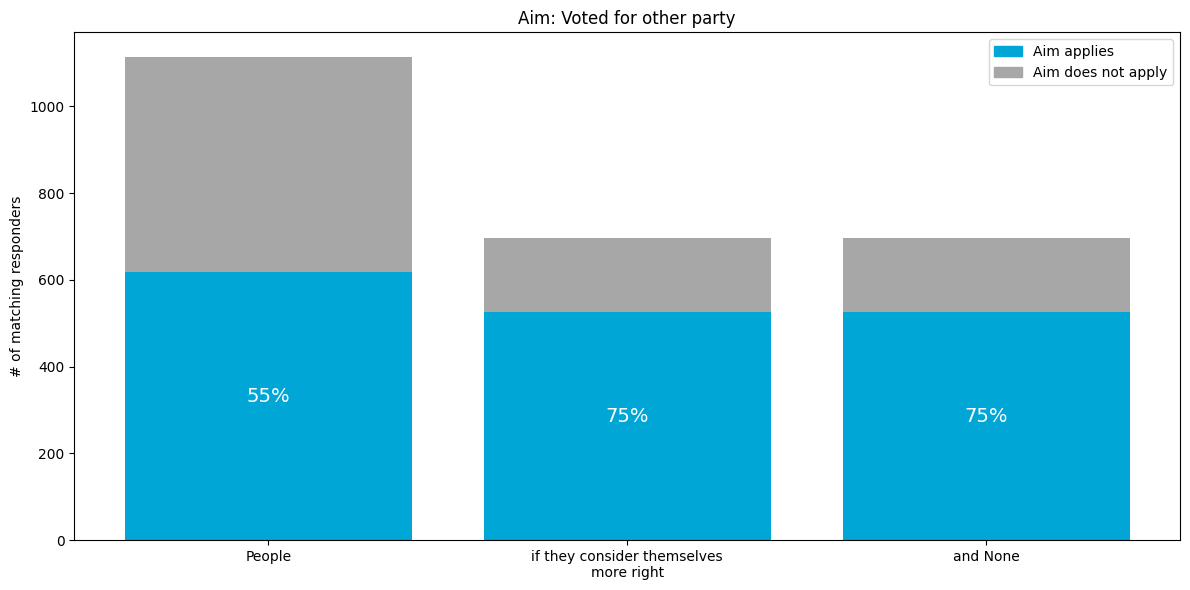

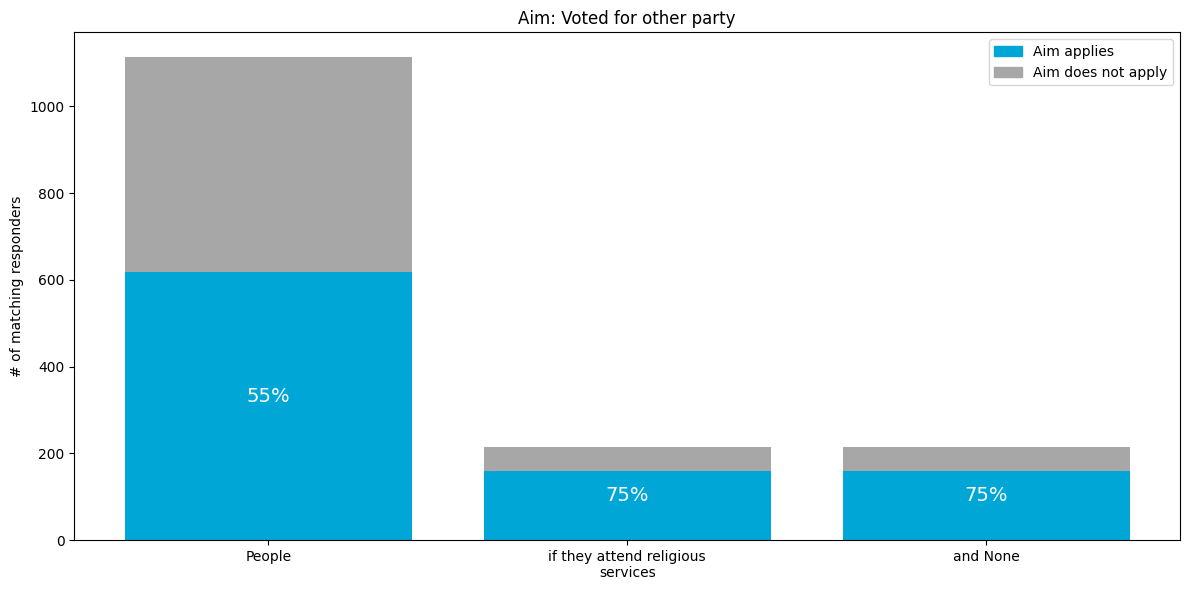

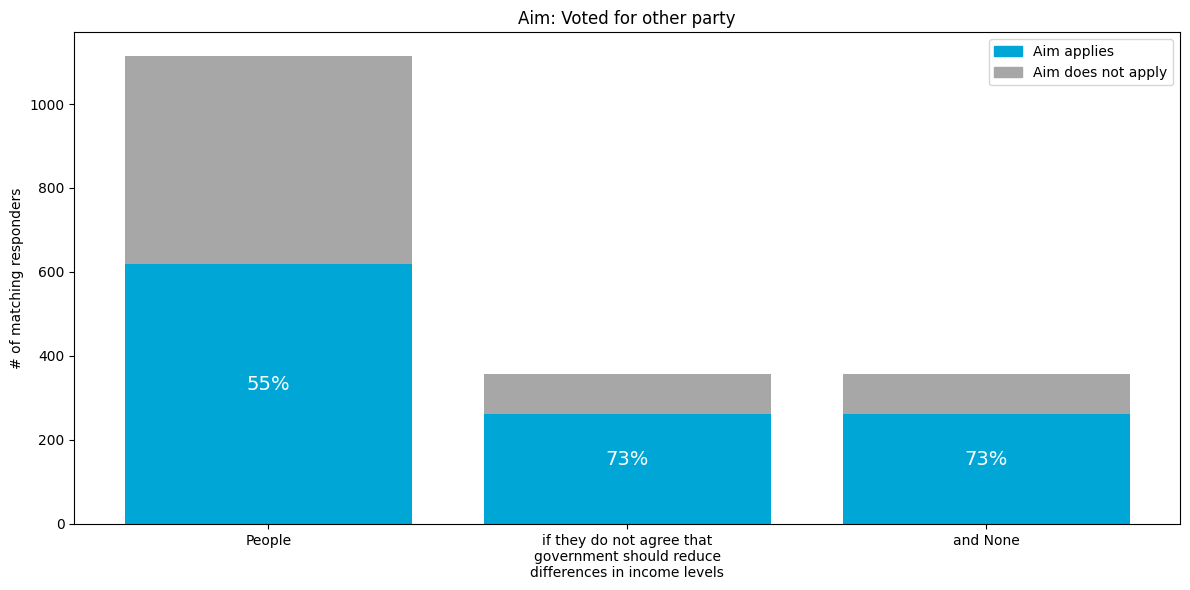

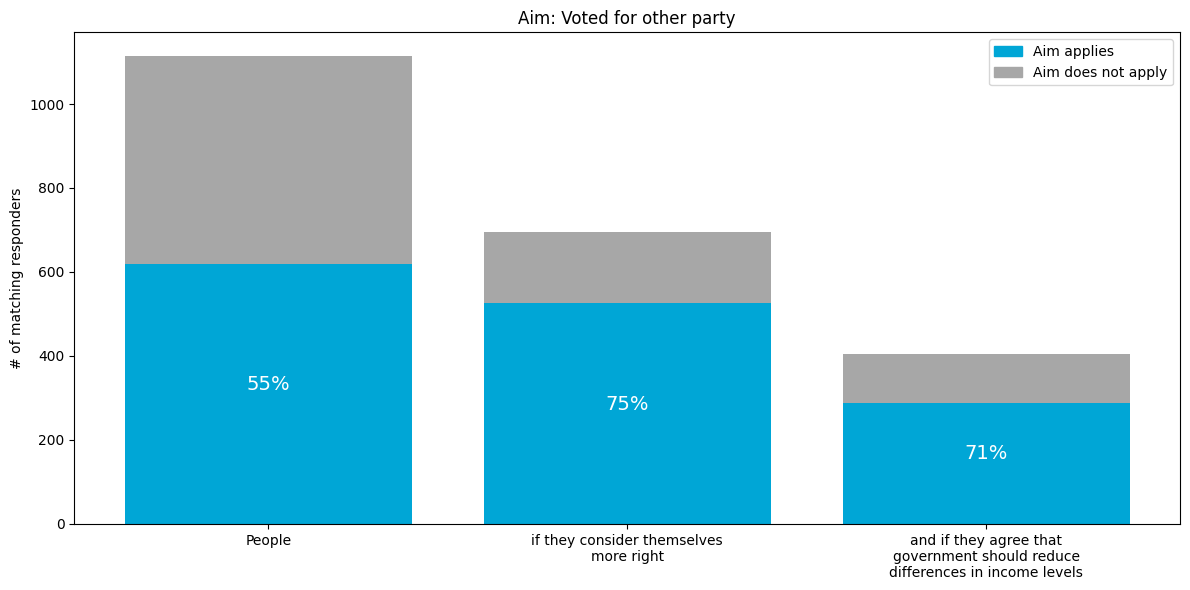

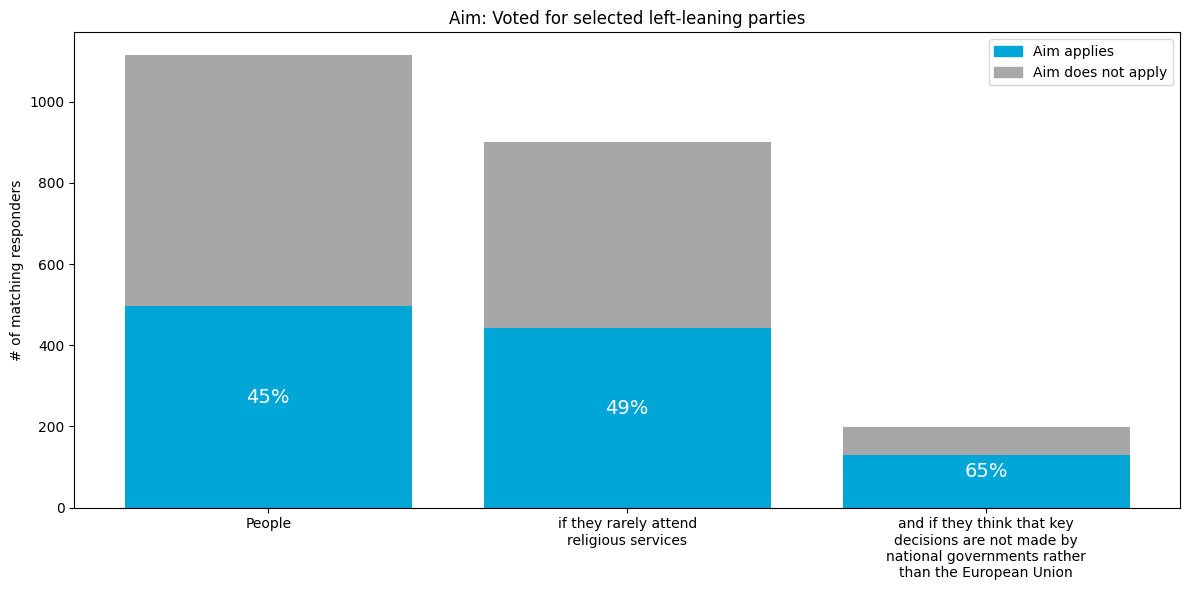

In [387]:
rows = len(statement_questions)

for i, row in statement_questions.iterrows():
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Adding legend
    blue_patch = mpatches.Patch(color='#00a6d6', label='Aim applies')
    grey_patch = mpatches.Patch(color='#a7a7a7', label='Aim does not apply')

    # Bar1: Total_count
    bar1 = ax.bar(str(row['Attribute']), row['Total_count'], color='#a7a7a7')
    ax.bar(str(row['Attribute']), row['Total_count'] * row['Aim_%_True'], color='#00a6d6')
    ax.text(str(row['Attribute']), row['Total_count'] * row['Aim_%_True']/2, f"{row['Aim_%_True']*100:.0f}%", 
            color='white', ha='center', va='bottom', fontsize=14)

    # Bar2: Condition1_count
    bar2 = ax.bar(str(row['Condition1']), row['Condition1_count'], color='#a7a7a7')
    ax.bar(str(row['Condition1']), row['Condition1_count'] * row['Condition1_Aim_%'], color='#00a6d6')
    ax.text(str(row['Condition1']), row['Condition1_count'] * row['Condition1_Aim_%']/2, f"{row['Condition1_Aim_%']*100:.0f}%", 
            color='white', ha='center', va='bottom', fontsize=14)

    # Bar3: Condition2_count
    bar3 = ax.bar(str(row['Condition2']), row['Condition2_count'], color='#a7a7a7')
    ax.bar(str(row['Condition2']), row['Condition2_count'] * row['Condition2_Aim_%'], color='#00a6d6')
    ax.text(str(row['Condition2']), row['Condition2_count'] * row['Condition2_Aim_%']/2, f"{row['Condition2_Aim_%']*100:.0f}%", 
            color='white', ha='center', va='bottom', fontsize=14)

    # Title of each plot
    ax.set_title("Aim: "+row['Aim_resp'])

    # Set ticks and labels
    ax.set_ylabel("# of matching responders")
    ax.set_xticks([0, 1, 2])
    wrapped_labels = [textwrap.fill(label, 30) for label in [row['Attribute'], row['Condition1_resp'], "and "+row['Condition2_resp']]]
    ax.set_xticklabels(wrapped_labels, rotation=0)

    ax.legend(handles=[blue_patch, grey_patch], loc='upper right')

    plt.tight_layout()
    plt.show()

In [388]:
def insert_linebreak(text):
    words = text.split()
    if len(words) > 10:
        middle_index = len(words) // 2
        words[middle_index] = words[middle_index] + "<br>"
        return " ".join(words)
    return text

In [391]:
import plotly.graph_objects as go
import pandas as pd
import textwrap

for i, row in statement_questions.iterrows():
    # Calculate values
    total_count = row['Total_count']
    condition1_count = row['Condition1_count']
    condition2_count = row['Condition2_count']
    
    aim_true_total = total_count * row['Aim_%_True']
    aim_false_total = total_count - aim_true_total
    
    aim_true_cond1 = condition1_count * row['Condition1_Aim_%']
    aim_false_cond1 = condition1_count - aim_true_cond1
    excluded_true_cond1 = aim_true_total - aim_true_cond1
    excluded_false_cond1 = aim_false_total - aim_false_cond1
    
    aim_true_cond2 = condition2_count * row['Condition2_Aim_%']
    aim_false_cond2 = condition2_count - aim_true_cond2
    excluded_true_cond2 = aim_true_cond1 - aim_true_cond2
    excluded_false_cond2 = aim_false_cond1 - aim_false_cond2

    # Define node labels with counts of leaving flows
    labels = [
        f"Applies: {round(aim_true_total)}{('<br>'*round(max(aim_true_total,aim_false_total)/total_count*24+1))}Does not apply: {round(aim_false_total)}",
        f"{round(aim_true_cond1)}{('<br>'*round((aim_true_cond1+excluded_true_cond1)/total_count*12+1))}{round(excluded_true_cond1)}",
        f"{round(aim_false_cond1)}{('<br>'*round((aim_false_cond1+excluded_false_cond1)/total_count*12+1))}{round(excluded_false_cond1)}",
        f"{round(aim_true_cond2)}{('<br>'*round((aim_true_cond2+excluded_true_cond2)/total_count*10+1))}{round(excluded_true_cond2)}",
        f"{round(aim_false_cond2)}{('<br>'*round((aim_false_cond2+excluded_false_cond2)/total_count*10+1))}{round(excluded_false_cond2)}",
        f"Applies: {aim_true_cond2:.0f}",
        f"Does not apply: {aim_false_cond2:.0f}",
        f"Excluded: {excluded_true_cond1 + excluded_false_cond1 + excluded_true_cond2 + excluded_false_cond2:.0f}"
    ]

    # Define links
    source = [0, 0, 1, 2, 1, 2, 3, 4, 3, 4]
    target = [1, 2, 3, 4, 7, 7, 5, 6, 7, 7]
    value = [
        aim_true_total, aim_false_total, 
        aim_true_cond1, aim_false_cond1, excluded_true_cond1, excluded_false_cond1, 
        aim_true_cond2, aim_false_cond2, excluded_true_cond2, excluded_false_cond2,
    ]

    # Color scheme
    color_aim_true = '#00a6d6'
    color_aim_false = '#a7a7a7'
    color_excluded = 'grey'

    link_colors = [color_aim_true, color_aim_false,
                   color_aim_true, color_aim_false, color_excluded, color_excluded, 
                   color_aim_true, color_aim_false, color_excluded, color_excluded]

    if not row["Condition2"]:
        labels = labels[0:3] + labels[5:]
        source = source[0:6]
        target = [1,2,3,4,5,5]
        value = value[0:6]
        link_colors = link_colors[0:6]
    
    
    # Create Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        arrangement = "perpendicular",
        node = dict(
        pad = 50,
        thickness = 20,
        line = dict(width = 0.5),
        label = labels,
        color = "blue",
        ),
        link = dict(
        source = source,
        target = target,
        value = value,
        color = link_colors
    ))])

    # Add invisible scatter traces for legend
    fig.add_trace(go.Scatter(
        x=[None], y=[None], mode='markers',
        marker=dict(size=15, color='#00a6d6'),
        name='Aim applies',
        showlegend=True
    ))

    fig.add_trace(go.Scatter(
        x=[None], y=[None], mode='markers',
        marker=dict(size=15, color='#a7a7a7'),
        name='Aim does not apply',
        showlegend=True
    ))

    fig.add_trace(go.Scatter(
        x=[None], y=[None], mode='markers',
        marker=dict(size=15, color='grey'),
        name='Excluded by conditions',
        showlegend=True,
    ))

    # Add annotations below the diagram
    if row["Condition2"]:
        annotations = [
            dict(x=0, y=-0.05, align="center", xref="paper", yref="paper", text=row['Attribute'], showarrow=False),
            dict(x=0.33, y=-0.07, align="center", xanchor="center", xref="paper", yref="paper", text=insert_linebreak(row['Condition1_resp']), showarrow=False),
            dict(x=0.66, y=-0.07, align="center", xanchor="center", xref="paper", yref="paper", text=insert_linebreak(row['Condition2_resp']), showarrow=False),
            dict(x=1, y=-0.05, align="center", xref="paper", yref="paper", text="final", showarrow=False)
        ]
    else:
        annotations = [
            dict(x=0, y=-0.05, align="center", xref="paper", yref="paper", text=row['Attribute'], showarrow=False),
            dict(x=0.5, y=-0.07, align="center", xanchor="center", xref="paper", yref="paper", text=insert_linebreak(row['Condition1_resp']), showarrow=False),
            dict(x=1, y=-0.05, align="center", xref="paper", yref="paper", text="final", showarrow=False)
        ]
    # Update layout
    fig.update_layout(
        title_text=f"""Sankey plot representation of an IG statement extracted by decision tree algorithm:<br>Aim: {row['Aim_resp']}""",
        font_size=18,
        height=700,  # Increased height to accommodate annotations
        width=1500,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=0.995,
            xanchor="right",
            x=1
        ),    
        # Hide axes
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        # Remove plot background
        plot_bgcolor='rgba(0,0,0,0)',
        # Add annotations
        annotations=annotations
    )

    fig.show()